**IMPORTANDO AS BIBLIOTECAS**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import warnings


from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')

In [ ]:
%%capture
!pip install torch pytorch-lightning pytorch_forecasting

import torch
import lightning.pytorch as pl
from pytorch_forecasting.data.encoders import GroupNormalizer
from lightning.pytorch.tuner import Tuner
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting.metrics import QuantileLoss, MultivariateNormalDistributionLoss
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, DeepAR, Baseline, MAE, BaseModel, MAPE, SMAPE
from torch.distributions import MultivariateNormal

**CARREGANDO OS DADOS**

In [ ]:
indices = pd.read_csv('/content/drive/MyDrive/PROJETO APLICADO/0105_dados/indices_merge.csv', index_col=0)
indices.data = pd.to_datetime(indices['data'])
#
insumos = pd.read_csv('/content/drive/MyDrive/PROJETO APLICADO/0105_dados/insumos_merge.csv', index_col=0)
insumos.data = pd.to_datetime(insumos['data'])

In [ ]:
# Copia dos dados importados
insumos1 = insumos.copy()
indices1 = indices.copy()

In [ ]:
# Transforma os dados em objeto
insumos1['codigo'] = insumos1['codigo'].astype(str)
insumos1['cod_rep'] = insumos1['cod_rep'].astype(str)

**Mesclando os dados para o treinamento do modelo**

In [ ]:
# Merclar os dados
df = pd.merge(indices1, insumos1, on='data', how='outer')

In [ ]:
# Retirar excedente dos dados
df_cortados = df.loc[df['data'] >= '2023-02-01']
df1 = df.loc[df['data'] < '2023-02-01']

#copiando os dados
df2 = df1.copy()

**SELECIONANDO OS DADOS PARA O TREINAMENTO**

In [ ]:
df3 = df2[['data', 'time_idx', 'codigo', 'cod_rep','commodities','valor','valor_var_mes', 'valor_var_cumsum', 'valor_cumsum', 'inpc_mes', 'inpc_mes_value', 'ipcc', 'ipcc_mes', 'ind_transf_value', 'commodities', 'selic_media_anual', 'tinta_value','CLASSE']]

In [ ]:
# Preenchendo os NAN
df3['valor_cumsum_fill'] = df3['valor_cumsum'].fillna(0)
# criando uma feature nova para dizer se os dados são reais ou não, por causa do fillna
df3['valor_cumsum_is_real'] = df3['valor_cumsum'].notna().astype(int)
# Reordernando os dados
df3 = df3.sort_values(by=['codigo', 'data'])

In [ ]:
df4 = df3.copy()

# Função para selecionar aleatoriamente uma amostra de cada grupo 'cod_rep'
def sample_from_group(group):
    return group.sample(n=3)

# Agrupar os dados por 'cod_rep' e selecionar uma amostra de cada grupo
sampled_data = df4.groupby('cod_rep').apply(sample_from_group).reset_index(drop=True)

# Obter a lista de 'codigo' selecionados
sampled_codigos = sampled_data['codigo'].unique()

# Filtrar os dados com base nos 'codigo' selecionados
train_data = df4[df4['codigo'].isin(sampled_codigos)]

train_data.shape

(51225, 20)

In [ ]:
df3.head()

data  time_idx codigo cod_rep commodities  valor  valor_var_mes  \
168  2010-01-01     168.0    100    9868         pvc  31.39            0.0   
2190 2010-02-01     169.0    100    9868         pvc  31.39            0.0   
4212 2010-03-01     170.0    100    9868         pvc  31.39            0.0   
6234 2010-04-01     171.0    100    9868         pvc  31.39            0.0   
8256 2010-05-01     172.0    100    9868         pvc  31.39            0.0   

      valor_var_cumsum  valor_cumsum  inpc_mes  inpc_mes_value  ipcc  \
168                0.0         100.0      0.88      248.878606   NaN   
2190               0.0         100.0      0.70      250.620756   NaN   
4212               0.0         100.0      0.71      252.400164   NaN   
6234               0.0         100.0      0.73      254.242685   NaN   
8256               0.0         100.0      0.43      255.335928   NaN   

      ipcc_mes  ind_transf_value commodities  selic_media_anual  tinta_value  \
168        NaN        101.500000         pvc                NaN   112.477648   
2190       NaN        102.748450         pvc                NaN   112.455153   
4212       NaN        102.584052         pvc                NaN   112.342698   
6234       NaN        102.994389         pvc                NaN   112.252823   
8256       NaN        103.478462         pvc                NaN   112.555906   

        CLASSE  valor_cumsum_fill  valor_cumsum_is_real  
168   PLASTICO              100.0                     1  
2190  PLASTICO              100.0                     1  
4212  PLASTICO              100.0                     1  
6234  PLASTICO              100.0                     1  
8256  PLASTICO              100.0                     1

SELECIONANDO A AMOSTRA PARA TREINO

In [ ]:
df4 = df3.copy()

# Carregar o dataframe

# Função para selecionar aleatoriamente uma amostra de cada grupo 'cod_rep'
def sample_from_group(group):
    return group.sample(n=3)

# Agrupar os dados por 'cod_rep' e selecionar uma amostra de cada grupo
sampled_data = df4.groupby('cod_rep').apply(sample_from_group).reset_index(drop=True)

# Obter a lista de 'codigo' selecionados
sampled_codigos = sampled_data['codigo'].unique()

# Filtrar os dados com base nos 'codigo' selecionados
train_data = df4[df4['codigo'].isin(sampled_codigos)]

train_data.shape

(51521, 20)

FEATURE ENGINEERING

In [ ]:
max_prediction_length = 6
max_encoder_length = 6*4




training_cutoff = train_data["time_idx"].max() - max_prediction_length


train_df = train_data[train_data['time_idx'] <= training_cutoff]
val_df = train_data[train_data['time_idx'] > training_cutoff]


def linear_trend(x):
    n = len(x)
    x_range = np.arange(n).reshape(-1, 1)
    model = LinearRegression()
    model.fit(x_range, x)
    return model.coef_[0]


# Calcule a média móvel e a diferença nos conjuntos de treinamento e validação separadamente
def create_features(df):
    df['valor_media_movel_3m'] = df.groupby('codigo')['valor_cumsum'].transform(lambda x: x.rolling(window=3).mean())
    df['valor_tendencia'] = df.groupby('codigo')['valor_cumsum'].transform(lambda x: x.rolling(window=3).apply(linear_trend))
    df['valor_media'] = df.groupby('codigo')['valor_cumsum'].transform(lambda x: x.rolling(window=3).mean())
    df['valor_std'] = df.groupby('codigo')['valor_cumsum'].transform(lambda x: x.rolling(window=3).std())
    df['mes'] = df['data'].dt.month
    df['trimestre'] = df['data'].dt.quarter
    df['ano'] =  df['data'].dt.year
    df = df.fillna(0)

    return df



train_df = create_features(train_df)
val_df = create_features(val_df)

# Concatene os conjuntos de treinamento e validação e use o resultado para criar o TimeSeriesDataSet
train_data_feat = pd.concat([train_df, val_df], ignore_index=True)


ano_minimo = train_data_feat['ano'].min()
train_data_feat['ano_numerico'] = train_data_feat['ano'] - ano_minimo + 1


In [ ]:
train_data_feat['time_idx'] = train_data_feat['time_idx'].astype(int)

df_selecionado = train_data_feat.select_dtypes(include=['int64', 'float64'])

if np.isinf(df_selecionado.any().any()):
    print("O DataFrame possui valores infinitos.")
else:
    print("O DataFrame não possui valores infinitos.")

In [ ]:
if np.isnan(df_selecionado.any().any()):
    print("O DataFrame possui valores nan.")
else:
    print("O DataFrame não possui valores nan.")

In [ ]:
print("Colunas do df_selecionado:")
print(df_selecionado.columns)
print("\nAmostra do df_selecionado:")
print(df_selecionado.head())

print("\nColunas do train_data_feat:")
print(train_data_feat.columns)
print("\nAmostra do train_data_feat:")
print(train_data_feat.head())

In [ ]:
train_data_feat.head()

In [ ]:
len(train_data_feat.codigo.unique())

PREDIZENDO VALOR_PCT_CUMSUM

In [ ]:
train_data_feat['time_idx'] = train_data_feat['time_idx'].astype(np.int64)
train_data_feat['valor_var_cumsum'] = train_data_feat['valor_var_cumsum'].astype(np.float32)

training = TimeSeriesDataSet(
    train_data_feat[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="valor_cumsum_fill",
    group_ids=["codigo"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["codigo",'cod_rep'],
    time_varying_known_reals= ["time_idx", "mes", "ano_numerico", "trimestre", 'inpc_mes_value'],
    time_varying_unknown_reals=[
        "valor_cumsum_fill",
        "valor_var_cumsum",
        'valor_media_movel_3m',
        'valor_tendencia',
        'valor_var_mes',
        'ind_transf_value',
        'valor_cumsum_is_real',
        'selic_media_anual',


    ],
    #target_normalizer=GroupNormalizer(
    #    groups=["codigo"], transformation="softplus"
   # ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,

)


validation = TimeSeriesDataSet.from_dataset(training, train_data_feat, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64
# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=30)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=30)

BASELINE DO PYTORCH

In [ ]:
# Calculate baseline mean absolute error
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)

# Calculate MAE
mae = MAE()(baseline_predictions.output, baseline_predictions.y)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MAPE
mape = MAPE()(baseline_predictions.output, baseline_predictions.y)
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# Calculate SMAPE
smape = SMAPE()(baseline_predictions.output, baseline_predictions.y)
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape}")


PARAMETROS DO MODELO

In [ ]:
pl.seed_everything(42)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.022,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate= 0.047,
    hidden_size=85,
    attention_head_size=2,
    dropout=0.206,
    hidden_continuous_size=29,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=10)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 21.5 K
3  | prescalers                         | ModuleDict             

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 5.106


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.150 >= min_delta = 0.0001. New best score: 4.956


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.077 >= min_delta = 0.0001. New best score: 4.879


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.210 >= min_delta = 0.0001. New best score: 4.670


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 4.670. Signaling Trainer to stop.


FINETUNING DO MODELO

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=40,
    max_epochs=15,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-05-01 23:17:24,657] A new study created in memory with name: no-name-41359bd2-57f2-4b0f-bdaa-1c5bcd4a799f
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-05-01 23:19:39,932] Trial 0 finished with value: 7.226287364959717 and parameters: {'gradient_clip_val': 0.022104331560473596, 'hidden_size': 38, 'dropout': 0.12078513669380314, 'hidden_continuous_size': 19, 'attention_head_size': 2, 'learning_rate': 0.00431775966368016}. Best is trial 0 with value: 7.226287364959717.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, usin

{'gradient_clip_val': 0.02237783346031679, 'hidden_size': 85, 'dropout': 0.2061790124373687, 'hidden_continuous_size': 29, 'attention_head_size': 2, 'learning_rate': 0.04753521523461863}


SALVANDO O MODELO

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_0/checkpoints/epoch=15-step=12672.ckpt


In [ ]:
model_path = '/content/drive/MyDrive/PROJETO APLICADO/model_TFT_2403/model_0105_v30.zip'

# zip o modelo e salvar na pasta
!zip -r model.zip lightning_logs/lightning_logs/version_0/*
!cp model.zip "{model_path}"

  adding: lightning_logs/lightning_logs/version_0/12672/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_0/12672/cod_rep/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_0/12672/cod_rep/metadata.tsv (deflated 56%)
  adding: lightning_logs/lightning_logs/version_0/12672/cod_rep/tensors.tsv (deflated 53%)
  adding: lightning_logs/lightning_logs/version_0/12672/codigo/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_0/12672/codigo/metadata.tsv (deflated 61%)
  adding: lightning_logs/lightning_logs/version_0/12672/codigo/tensors.tsv (deflated 54%)
  adding: lightning_logs/lightning_logs/version_0/checkpoints/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_0/checkpoints/epoch=15-step=12672.ckpt (deflated 10%)
  adding: lightning_logs/lightning_logs/version_0/events.out.tfevents.1683598026.9642a192645b.1949.1 (deflated 14%)
  adding: lightning_logs/lightning_logs/version_0/hparams.yaml (deflated 85%)
  adding: lightning_logs/lightning_logs/ver

CARREGANDO O MODELO

In [ ]:
best_model_path='lightning_logs/lightning_logs/version_0/checkpoints/epoch=15-step=12672.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

METRICAS DO MODELO

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to('cuda')
predictions = best_tft.predict(val_dataloader).to('cuda')

#average p50 loss overall
print('MAE:', (actuals - predictions).abs().mean().item())

#average p50 loss per time series
mape = ((actuals - predictions).abs() / actuals).mean()
print('MAPE:', (mape * 100).item(), '%')

smape = (2.0 * (actuals - predictions).abs() / (actuals.abs() + predictions.abs())).mean()
print('SMAPE:', (smape * 100).item(), '%')

INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE: 8.958916664123535
MAPE: 4.011986255645752 %
SMAPE: 3.9235804080963135 %


In [ ]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
x = raw_predictions[1]
print(raw_predictions._fields)  # ('output', 'x', 'index', 'decoder_lengths', 'y')
print('\n')
print(len(raw_predictions.output))


INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


('output', 'x', 'index', 'decoder_lengths', 'y')


8


GRAFICOS DOS PRIMEIRO 50 ITENS PREVISTOS

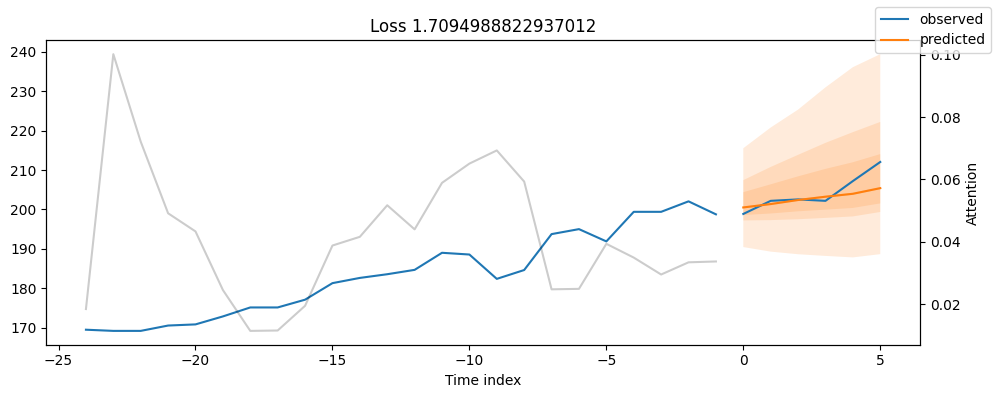

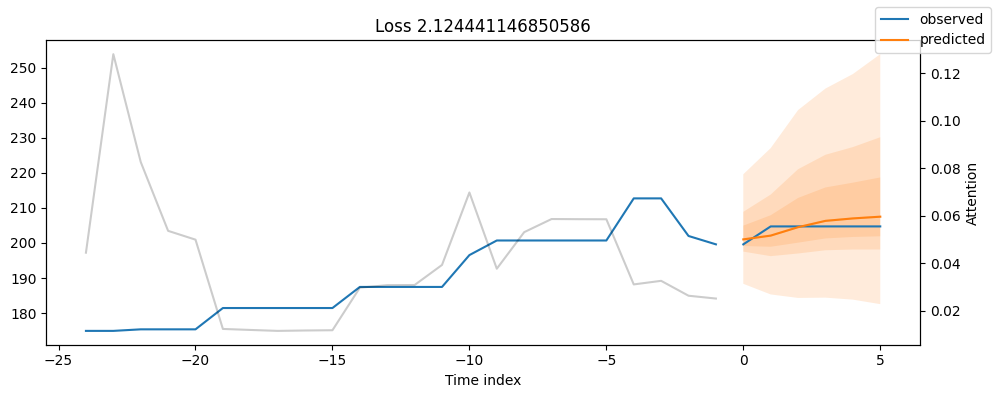

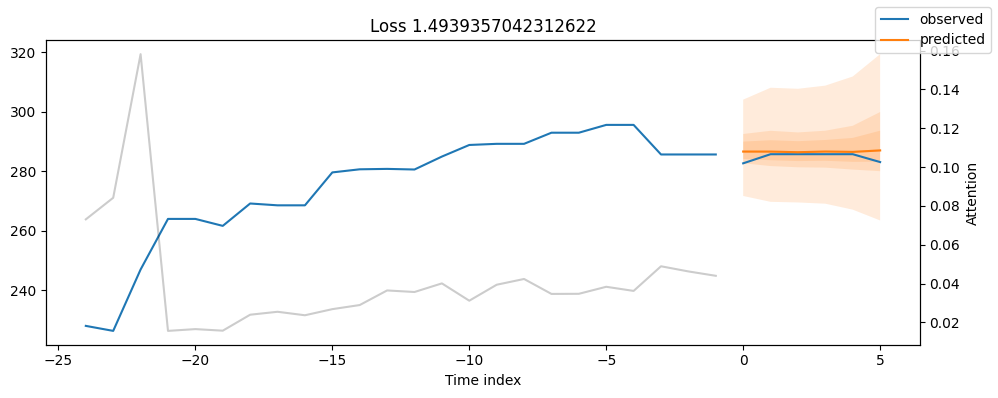

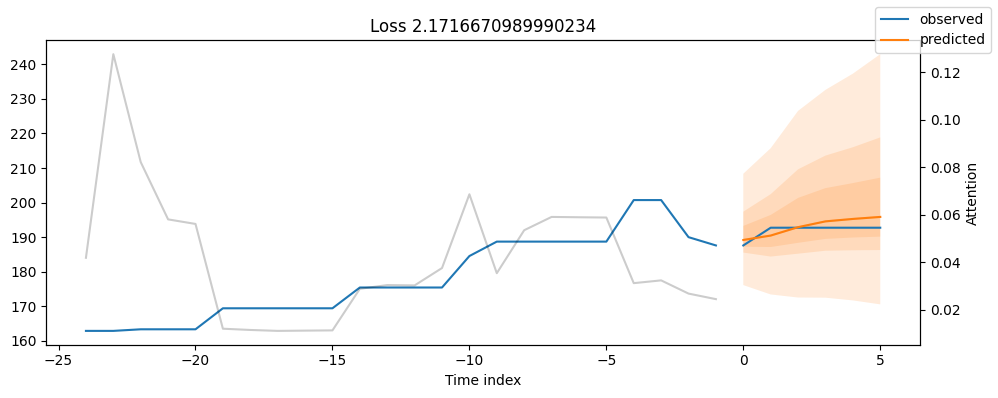

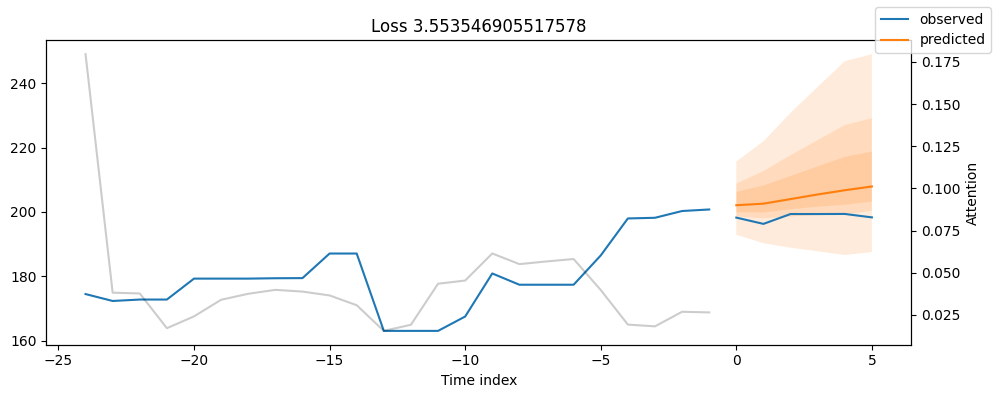

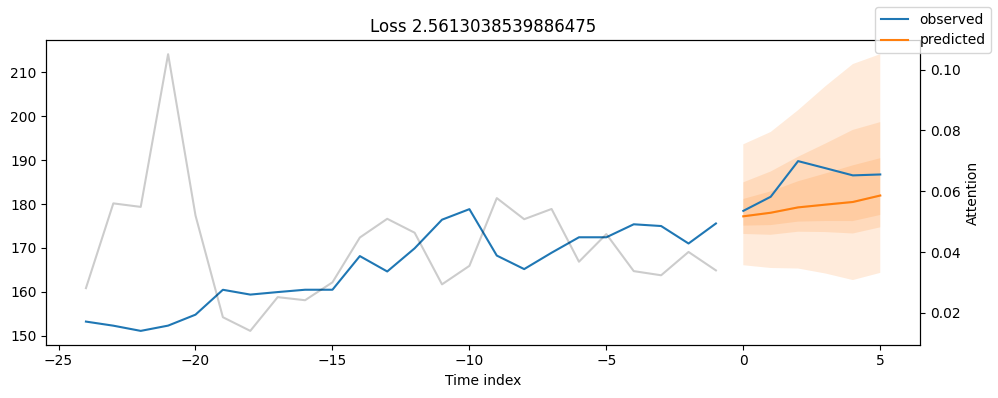

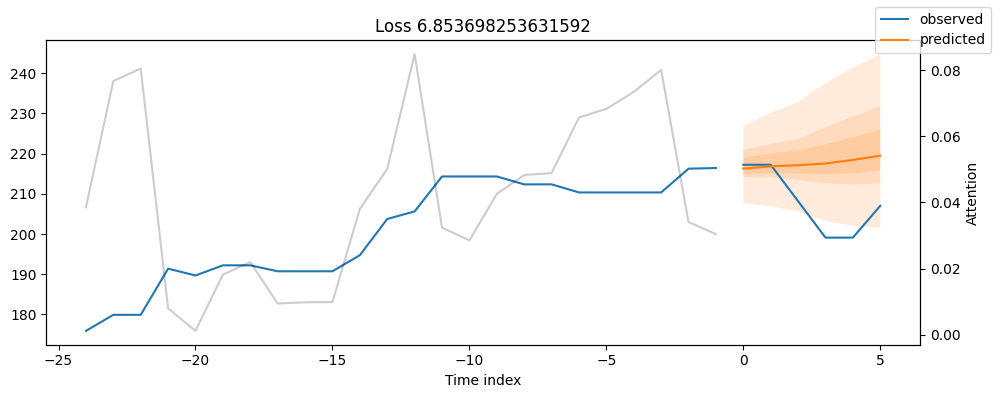

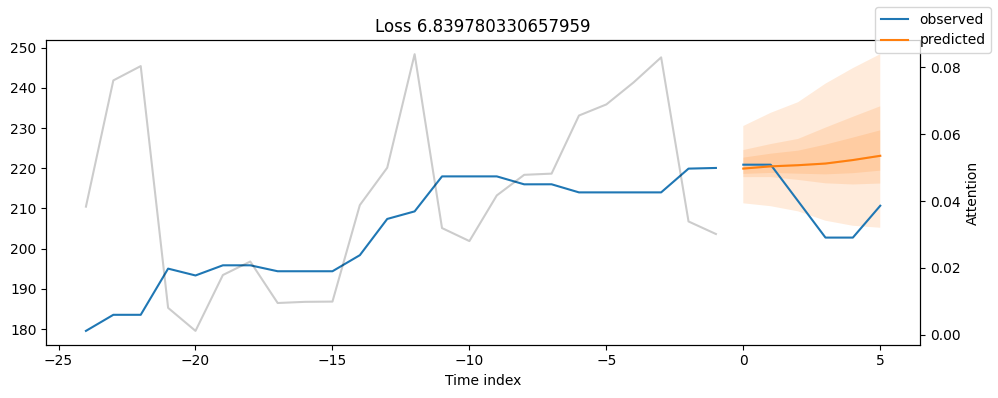

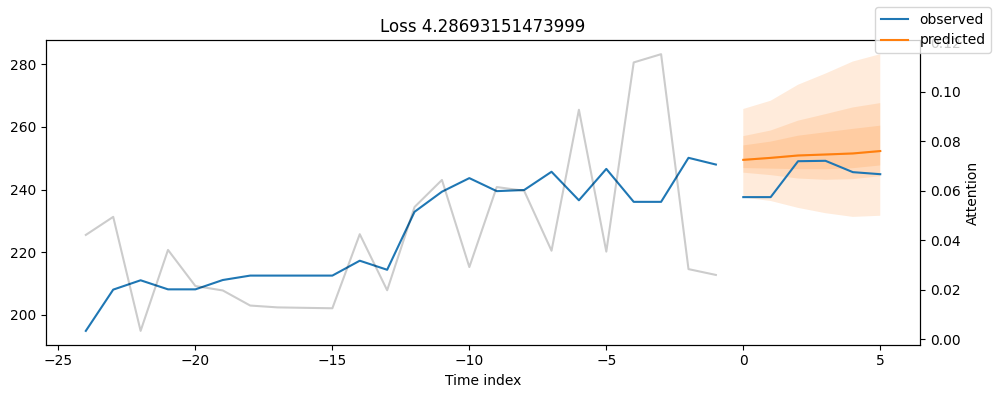

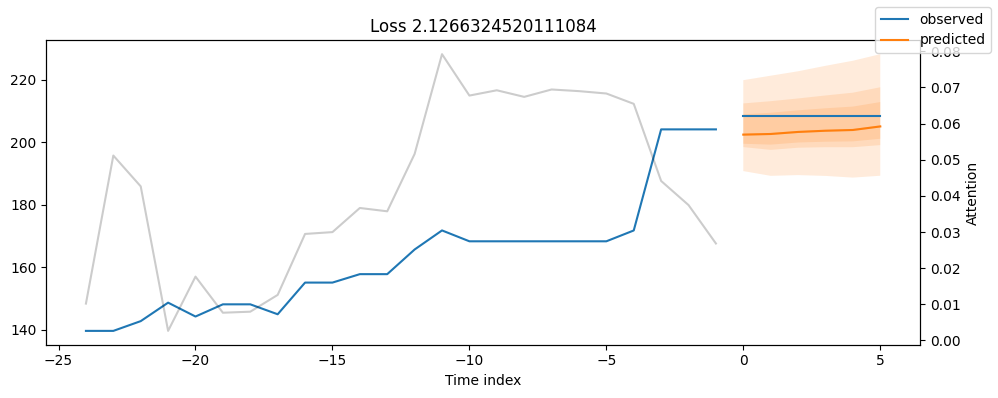

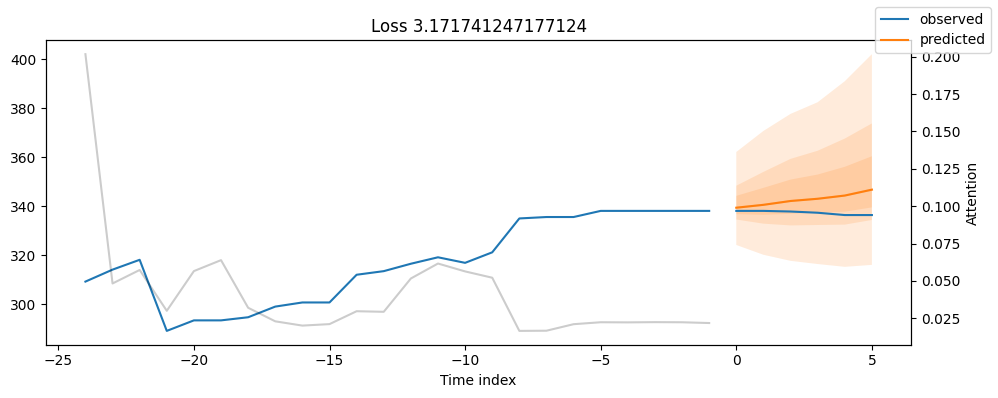

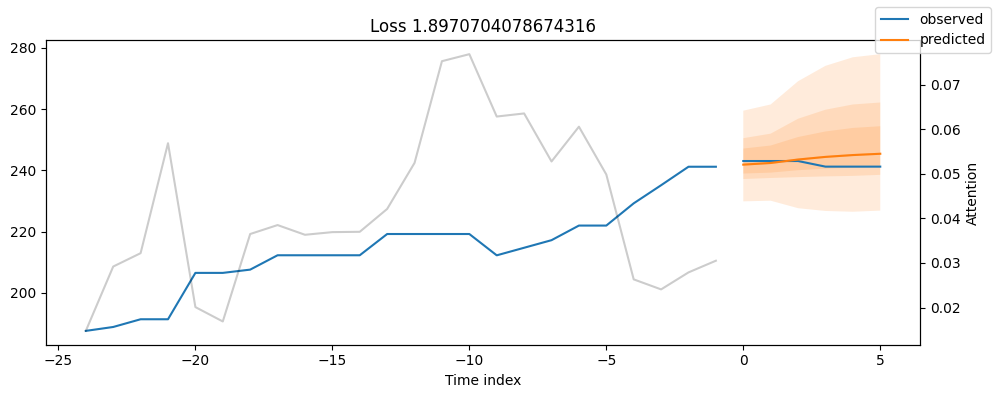

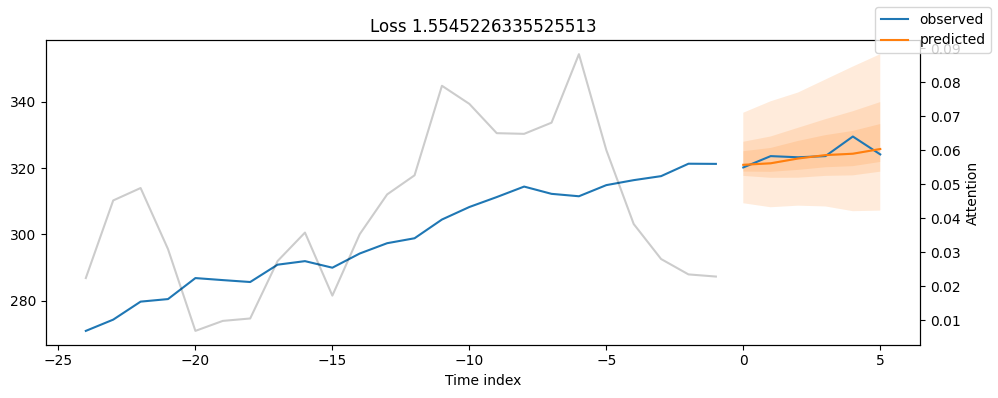

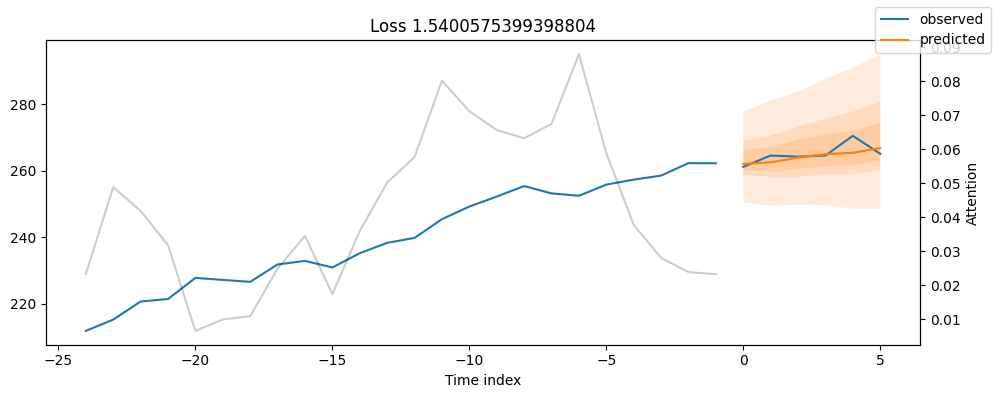

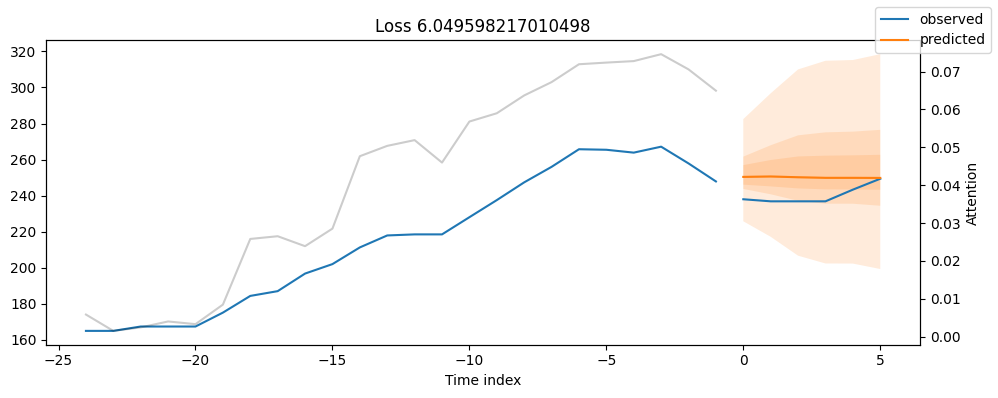

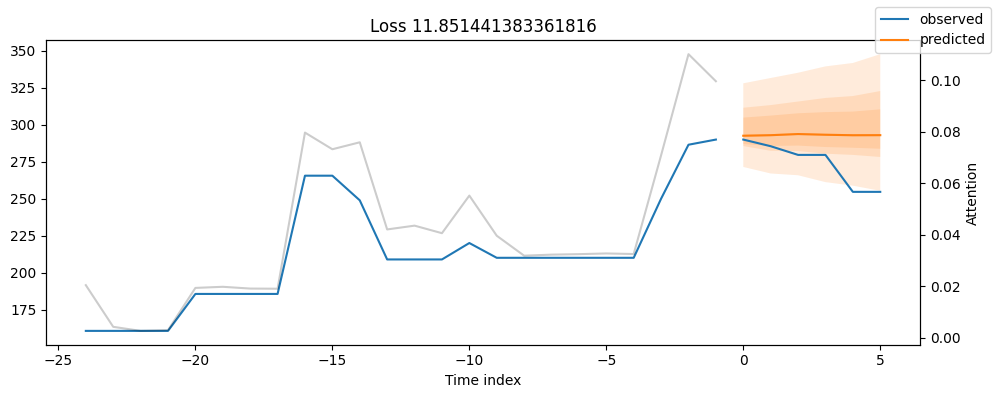

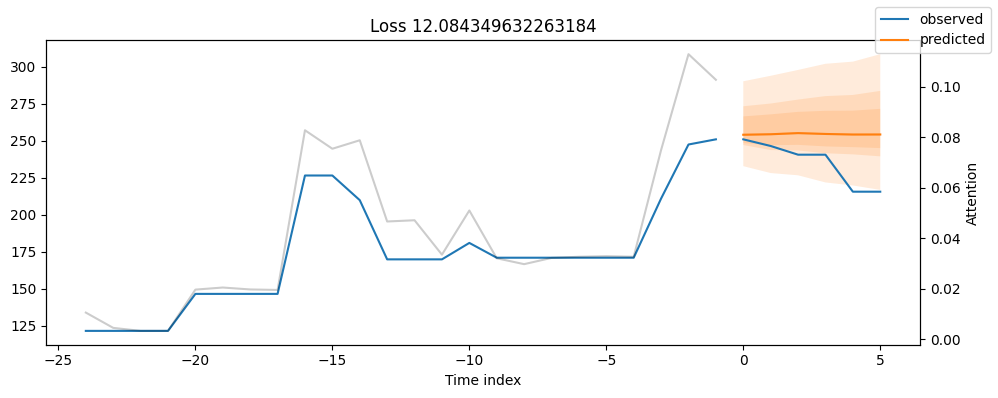

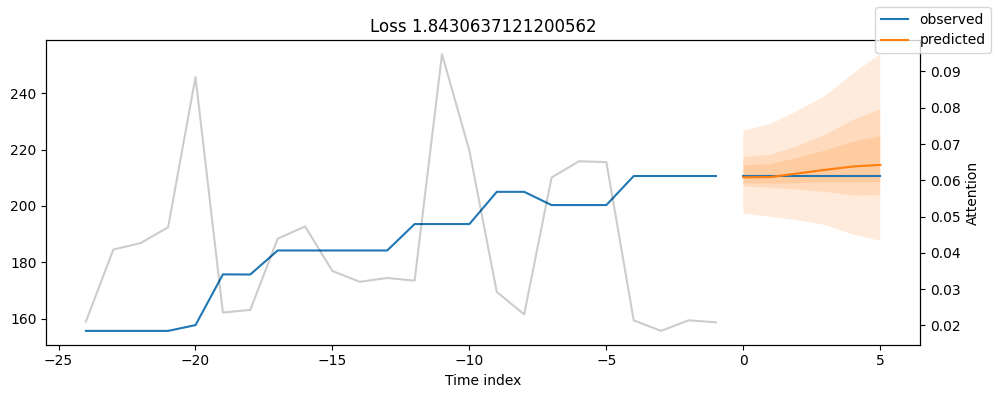

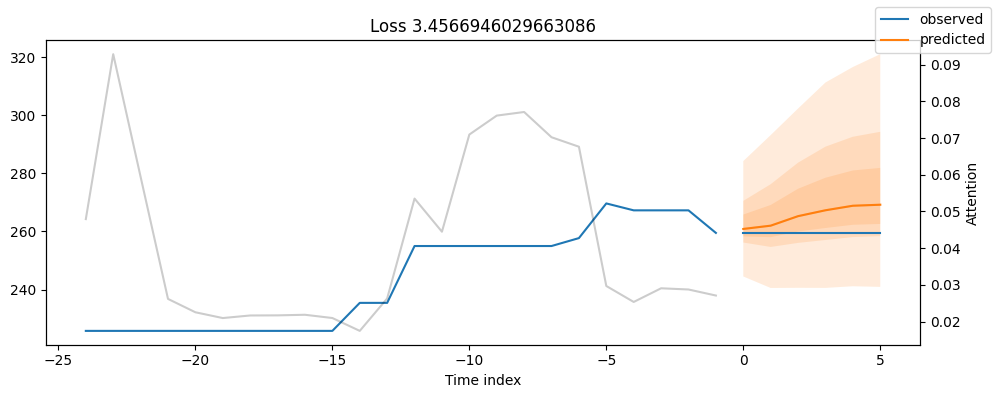

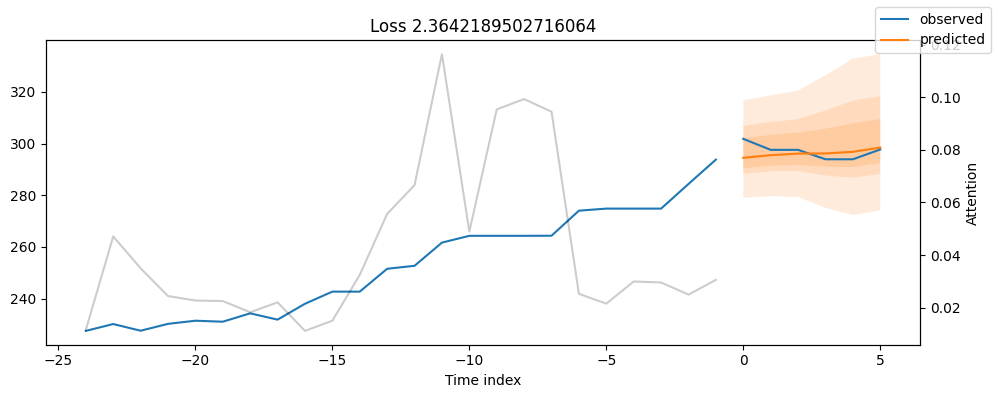

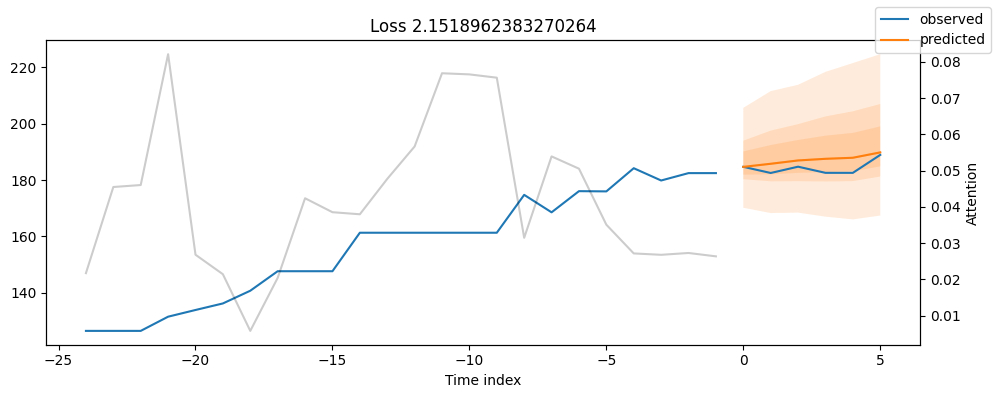

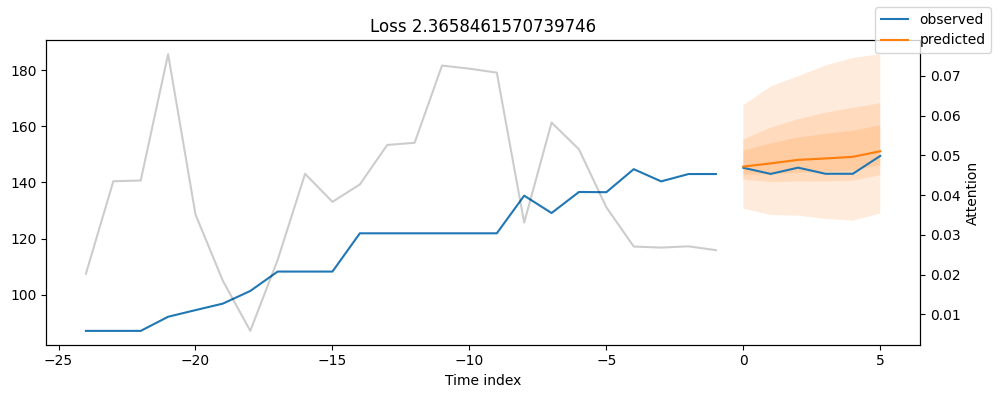

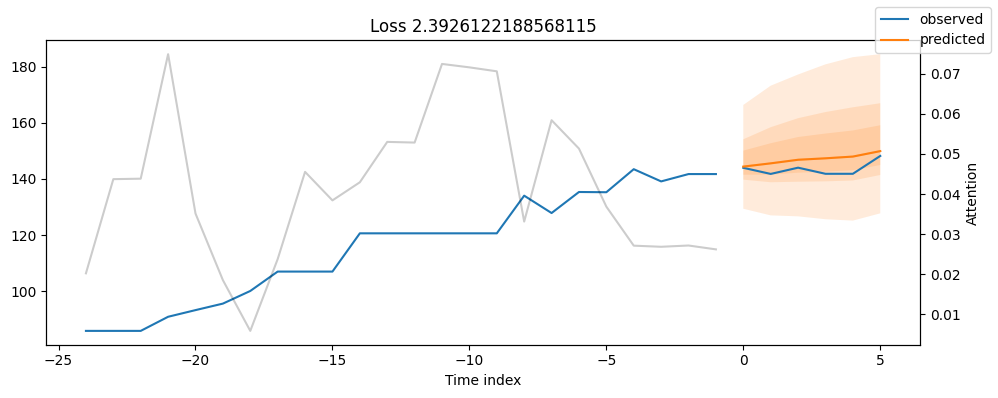

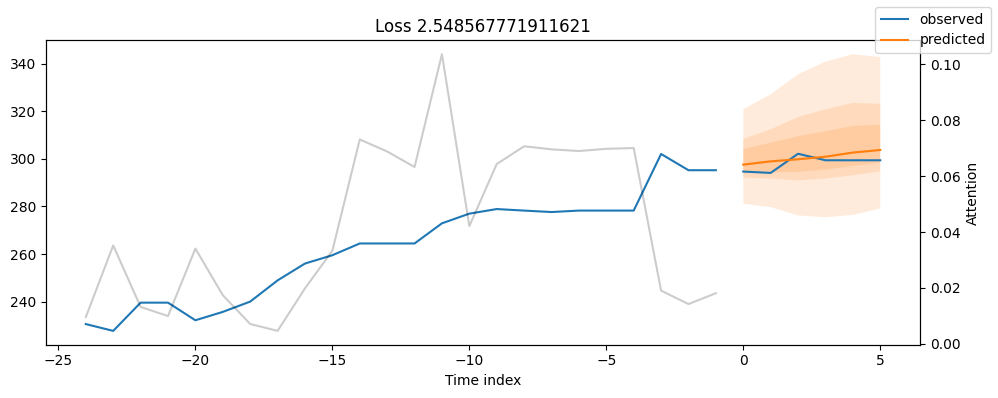

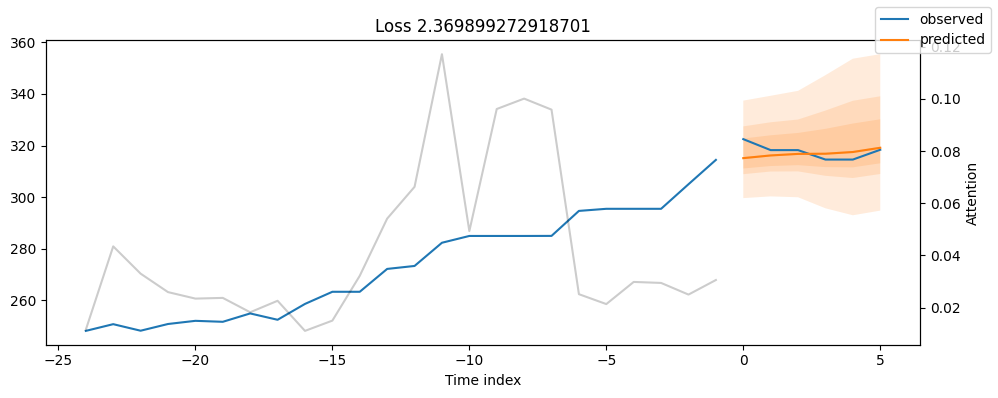

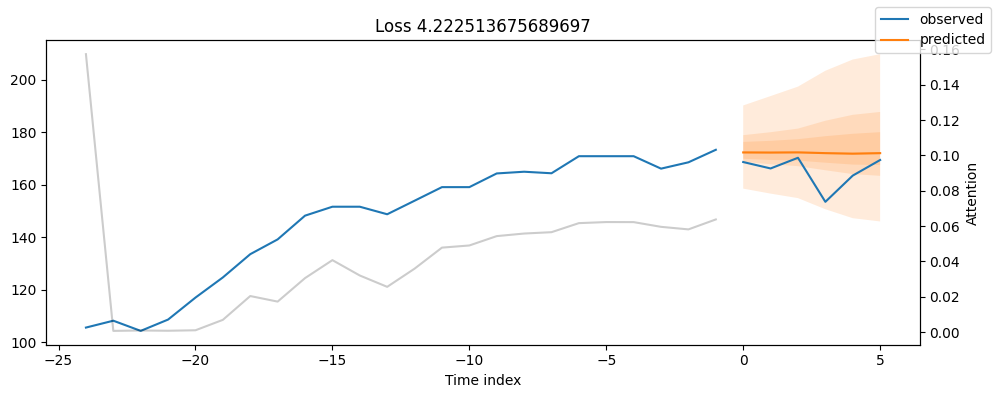

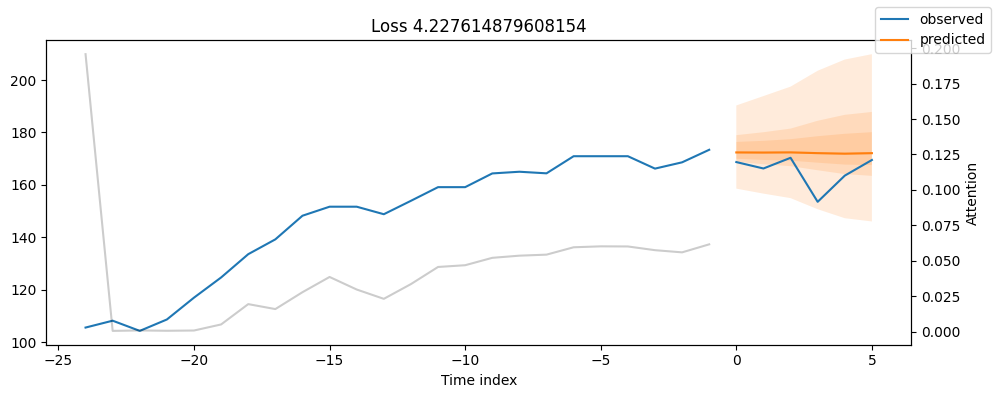

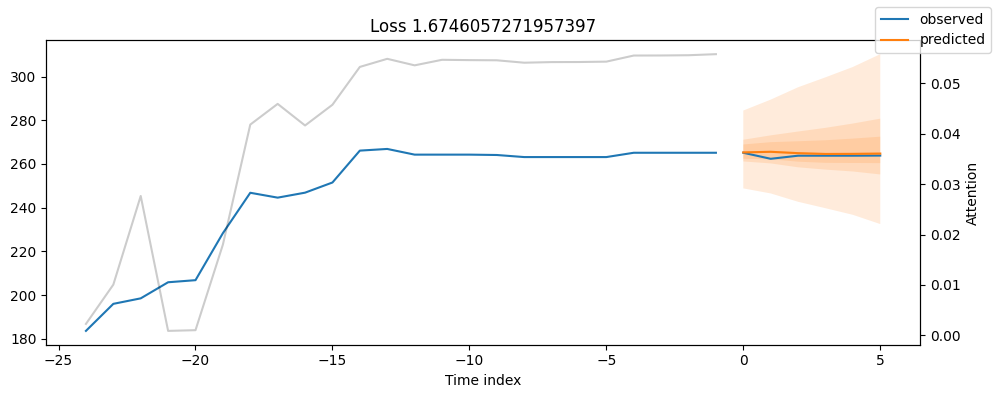

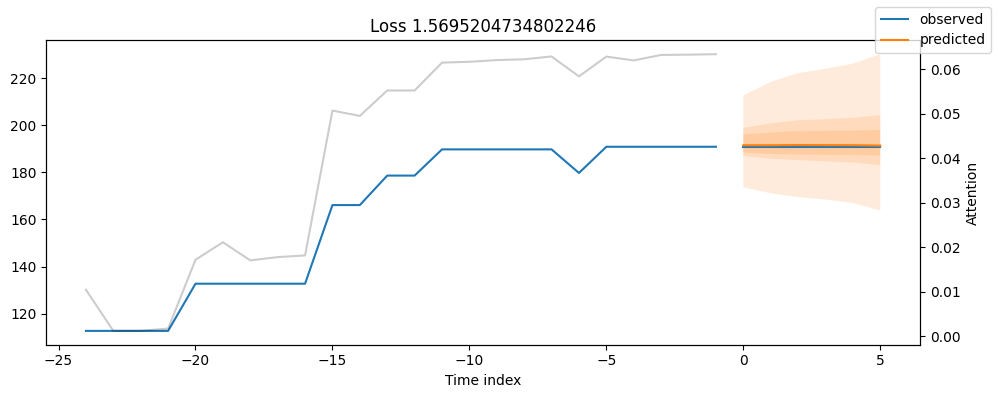

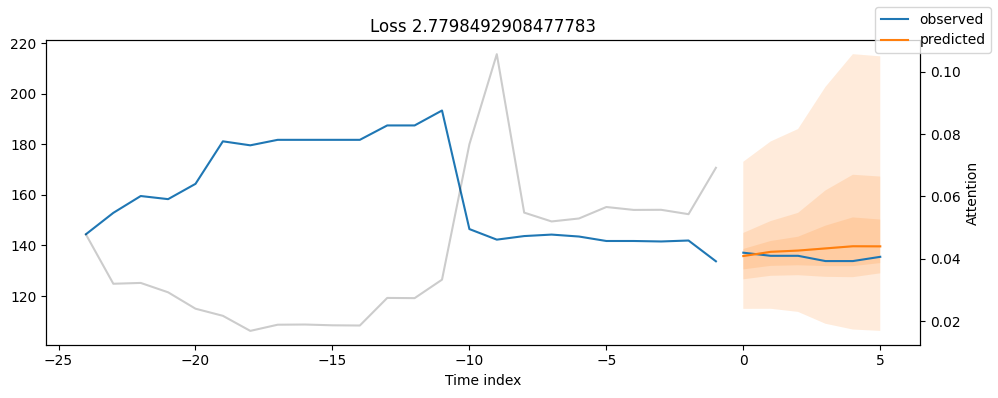

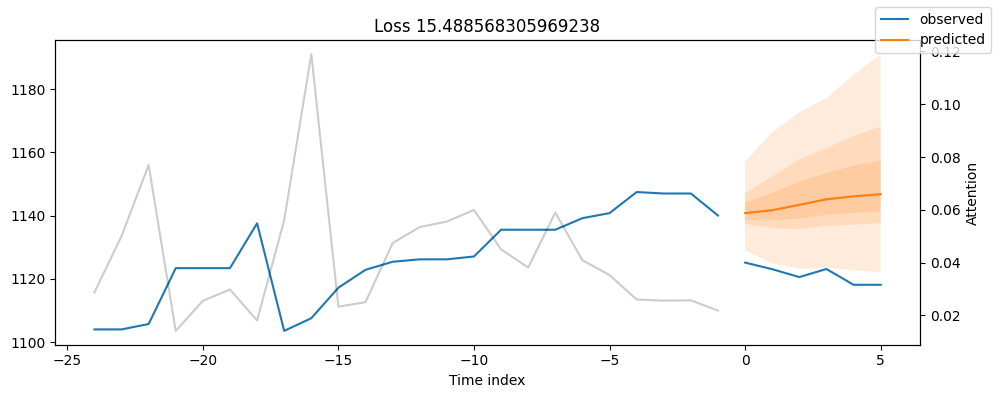

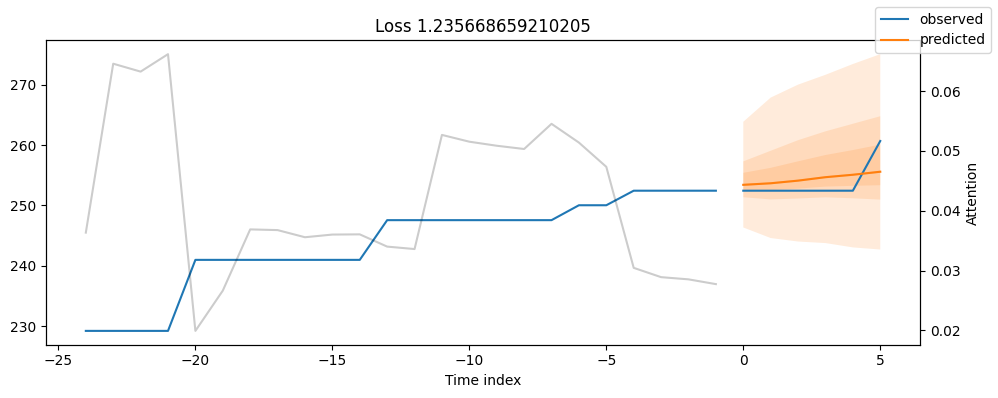

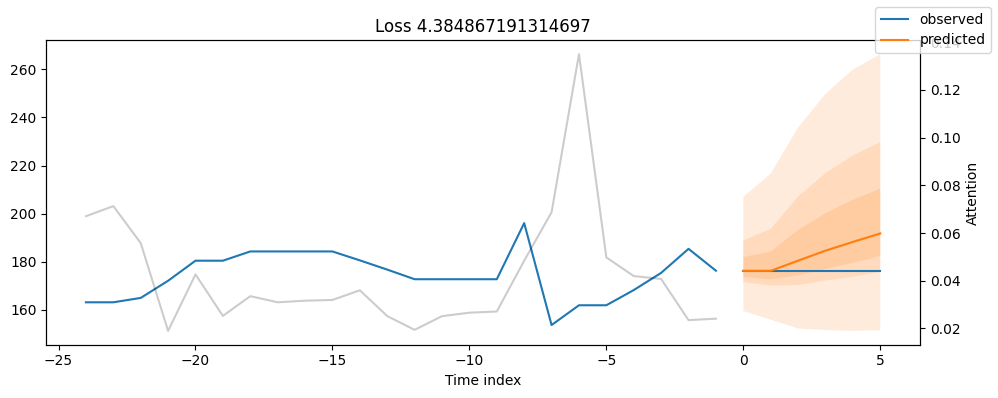

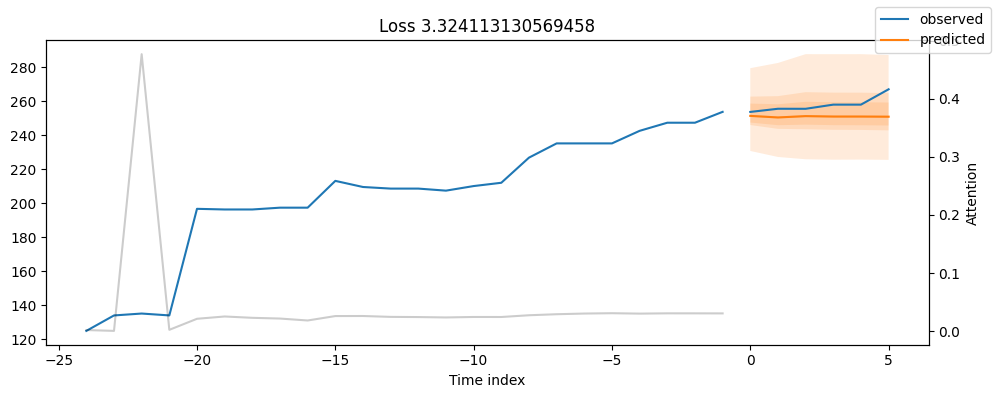

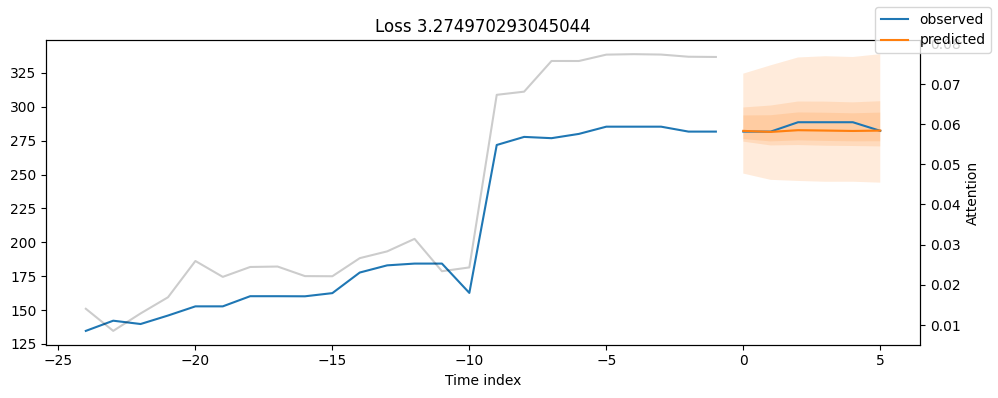

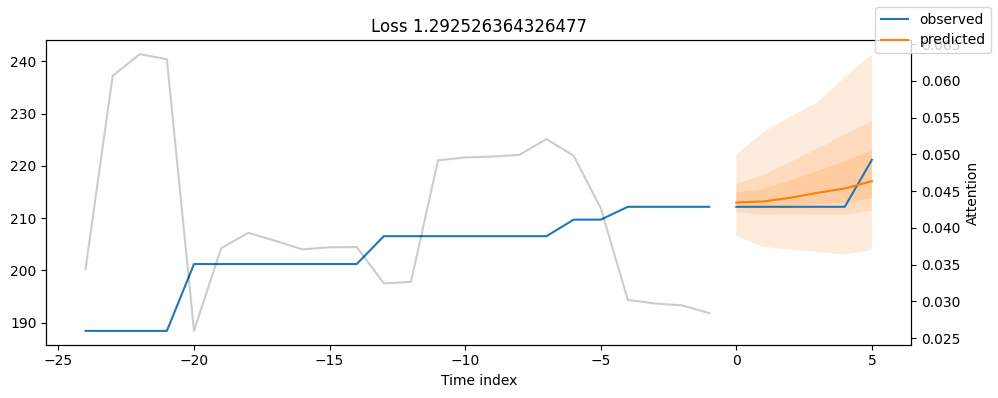

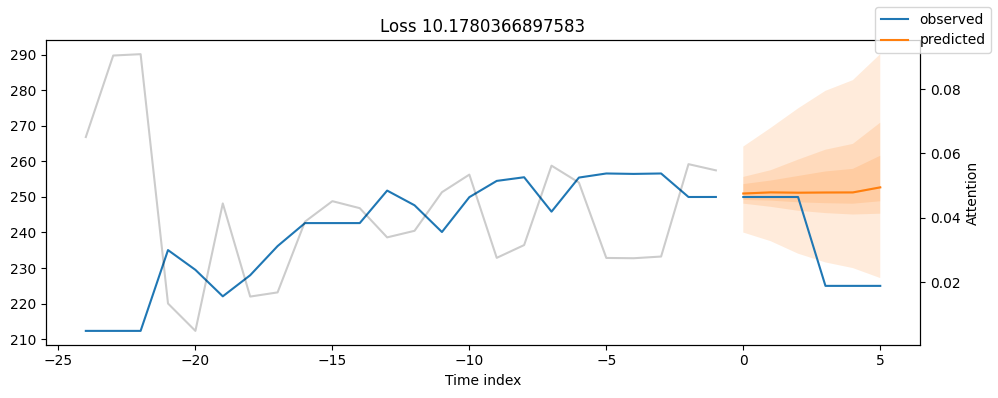

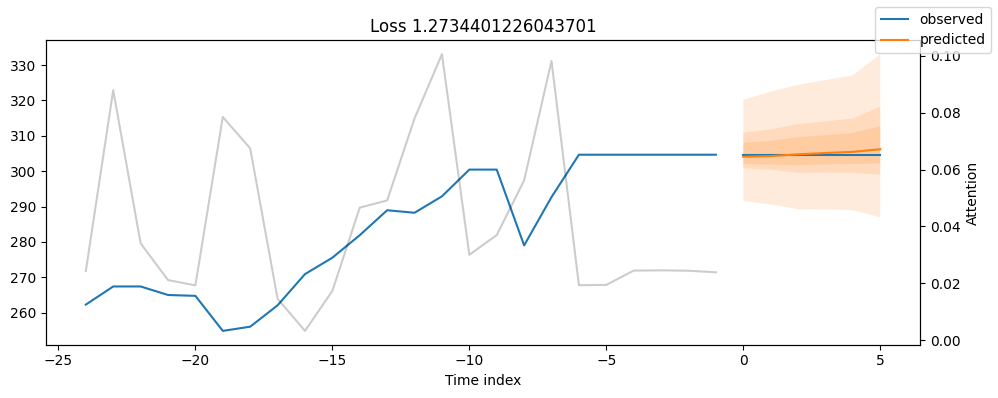

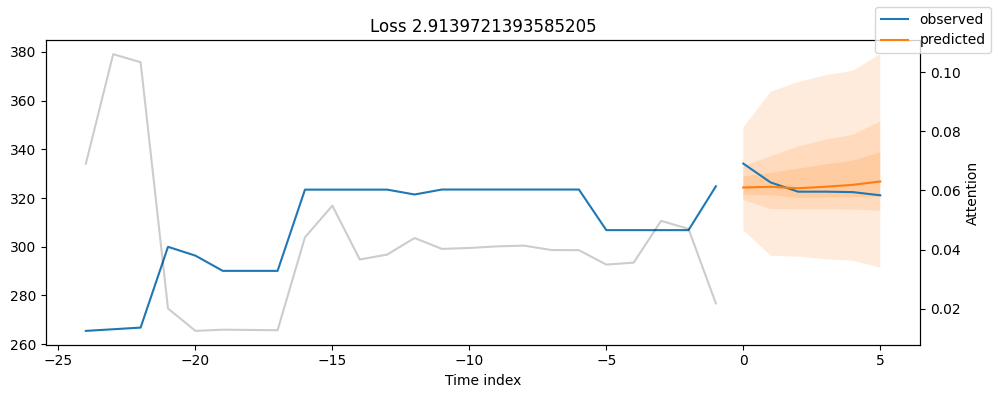

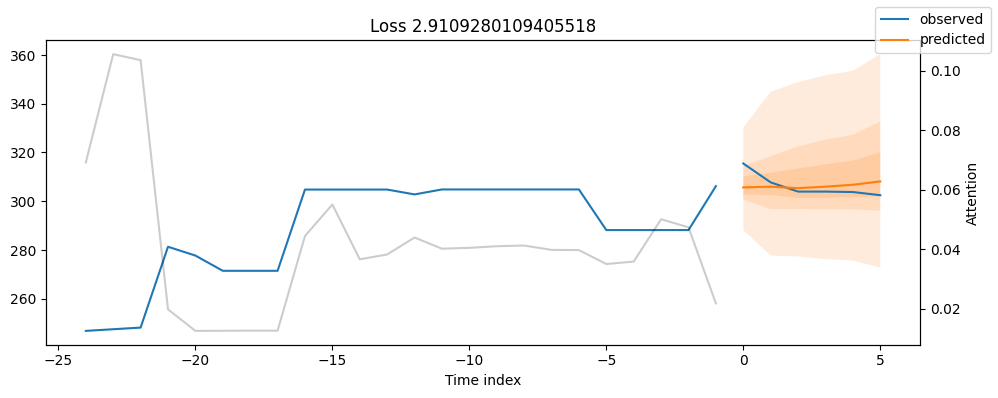

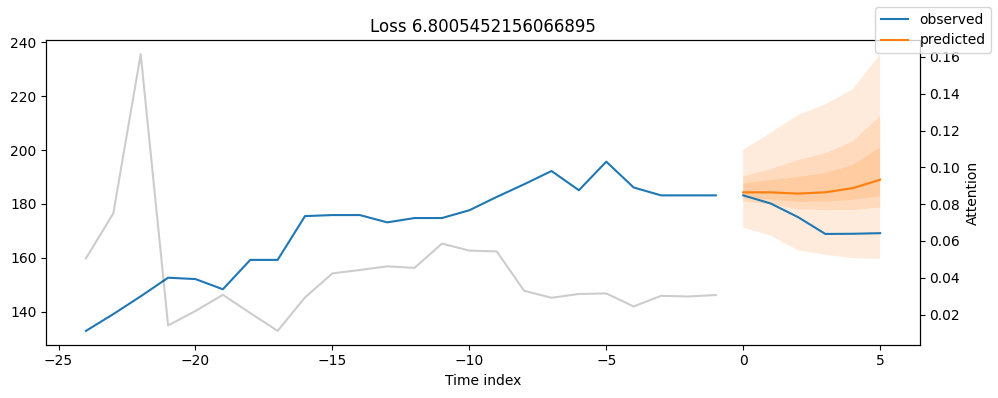

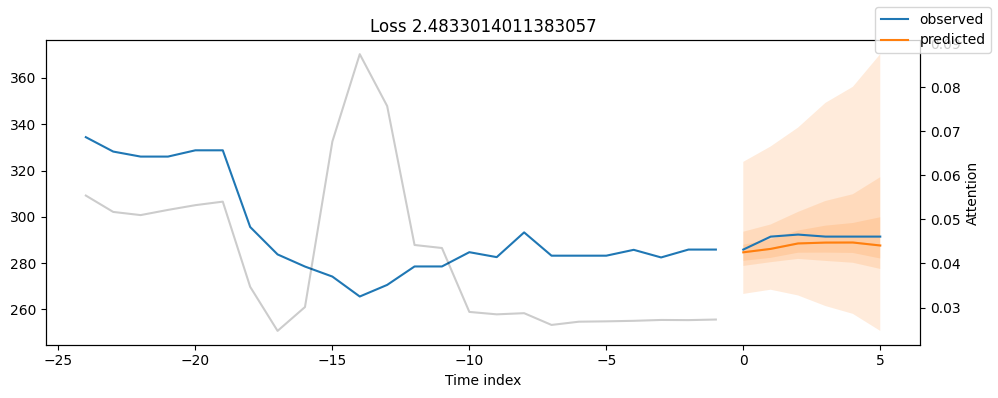

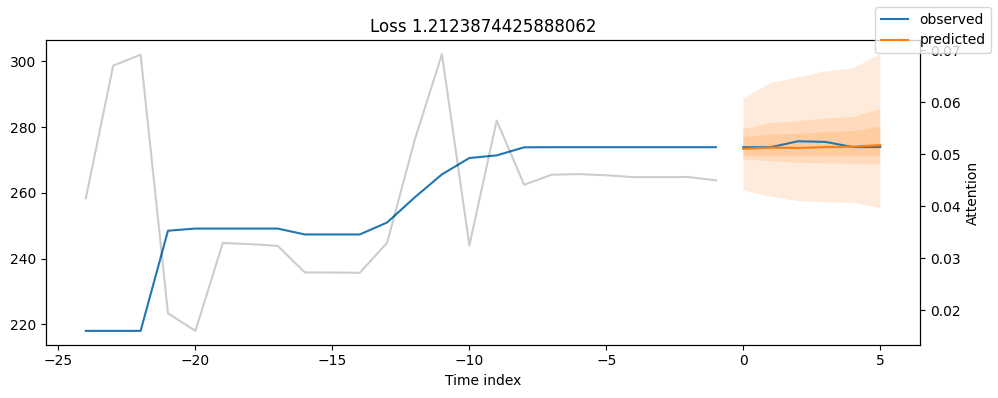

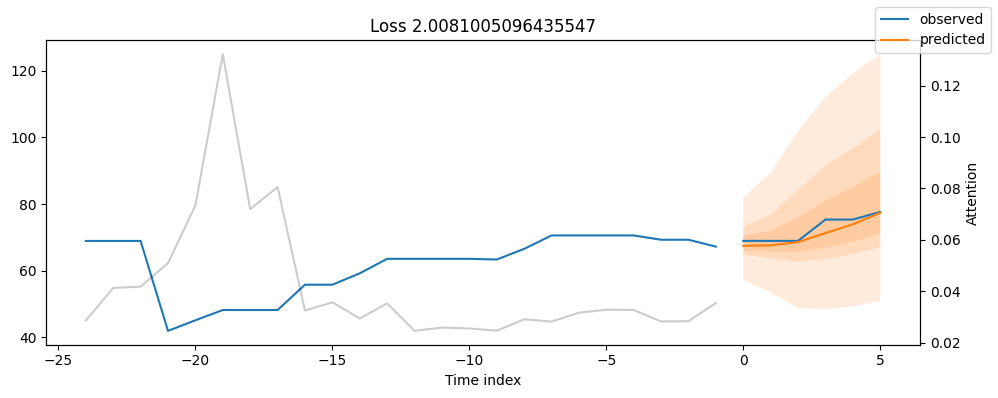

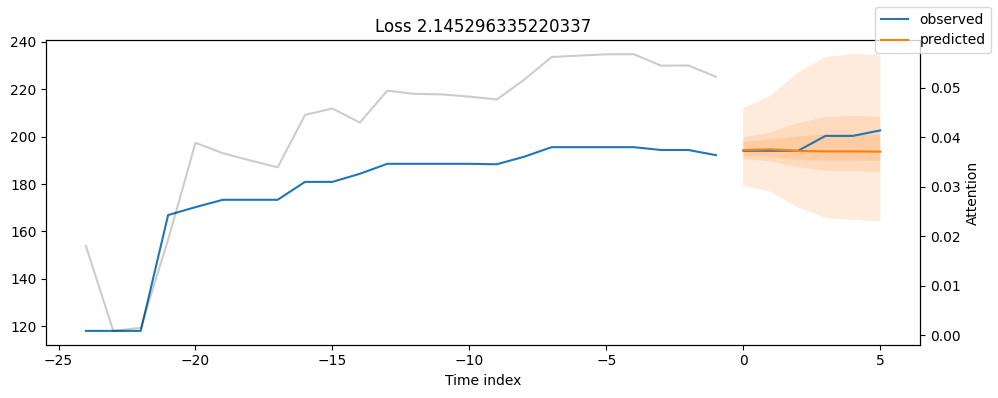

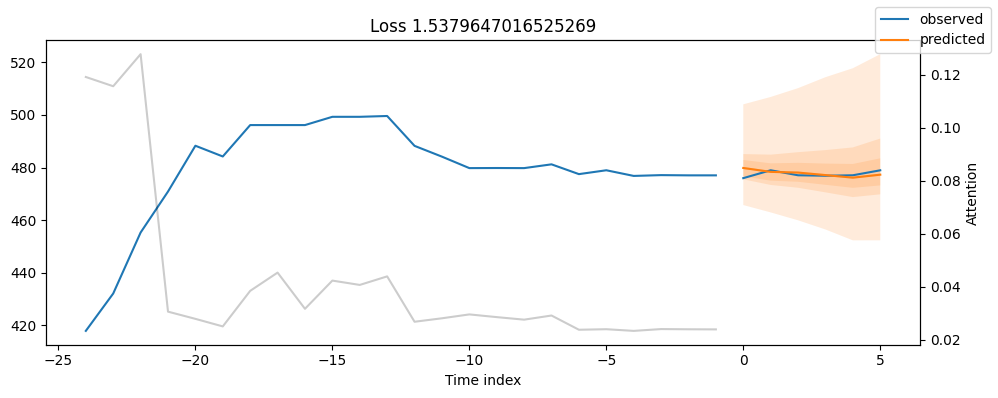

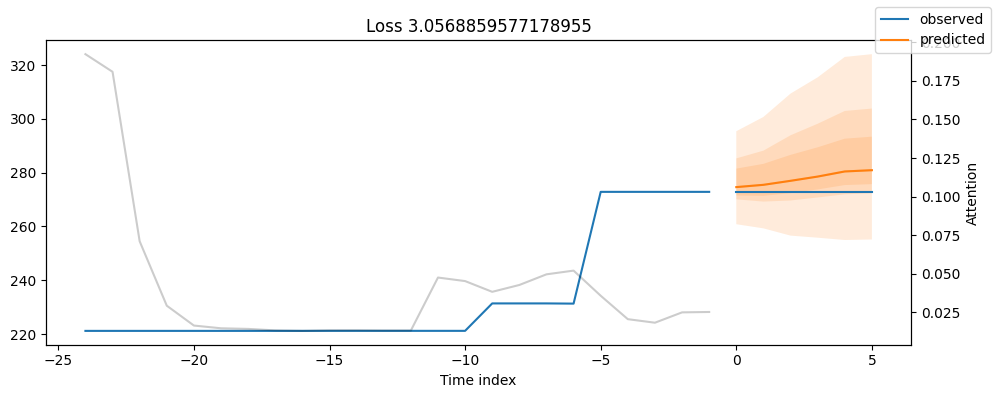

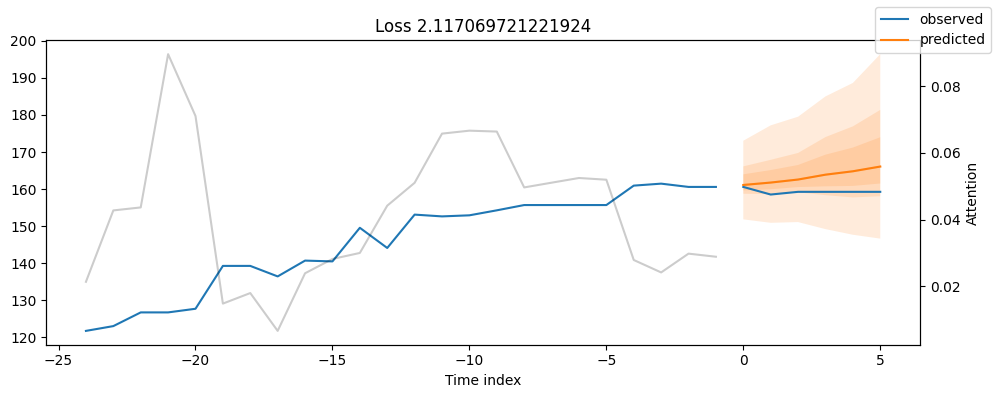

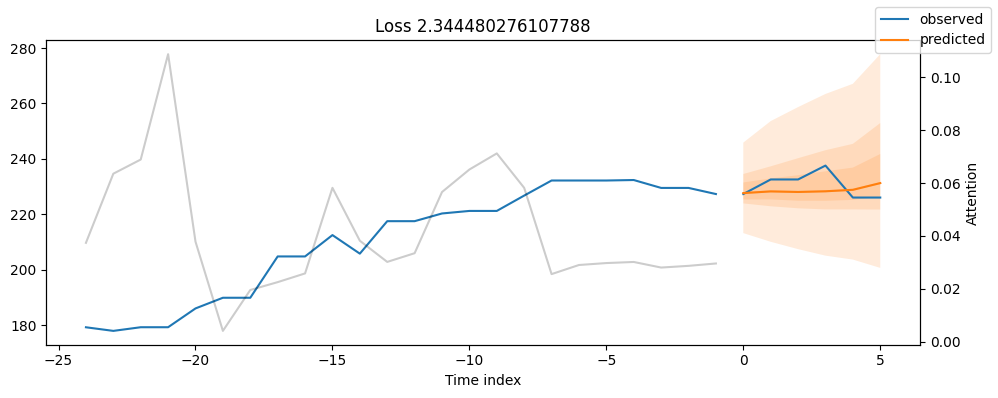

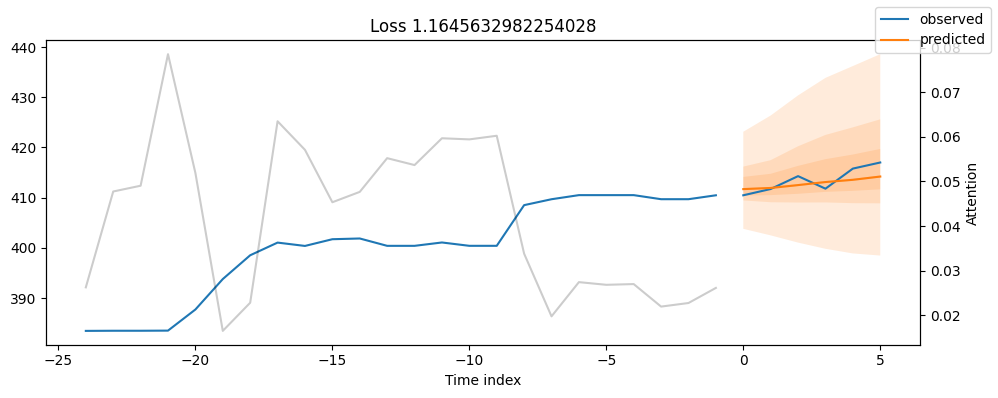

In [ ]:
for idx in range(50):  # plot 10 examples
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True, ax=ax)

**GRAFICO COM OS PIORES DESEMPENHOS**

INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


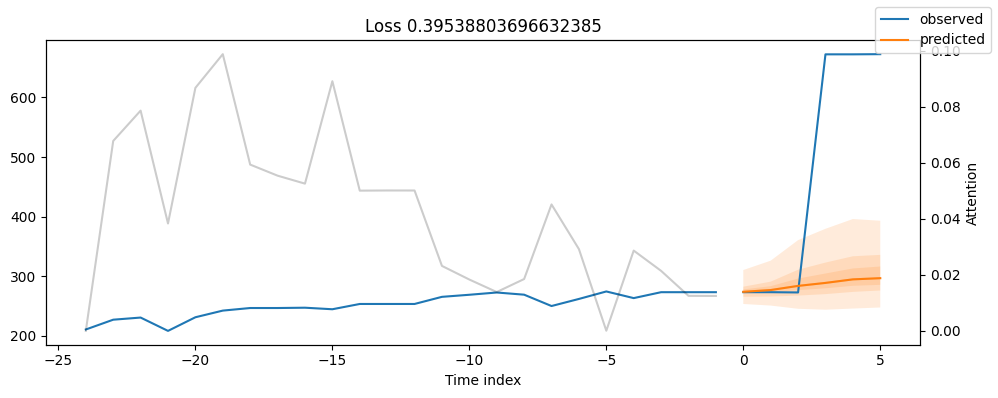

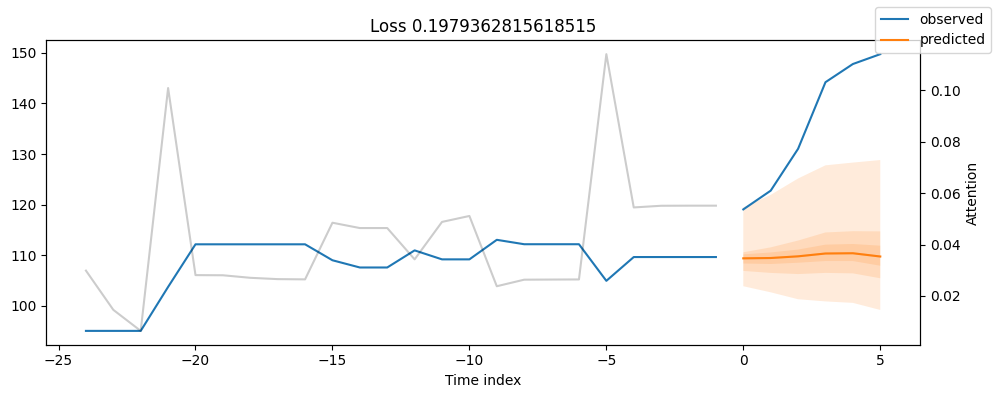

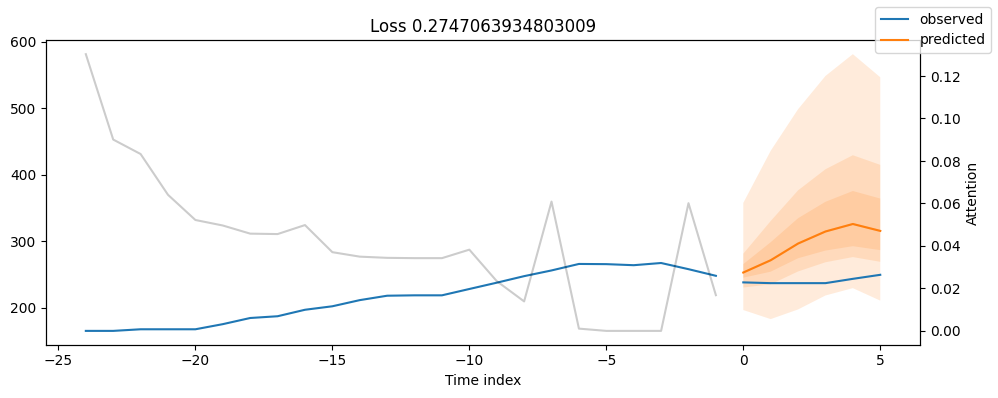

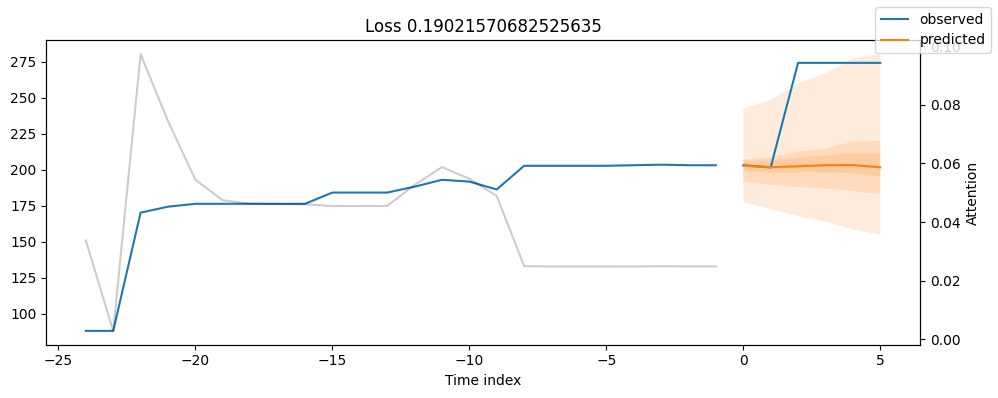

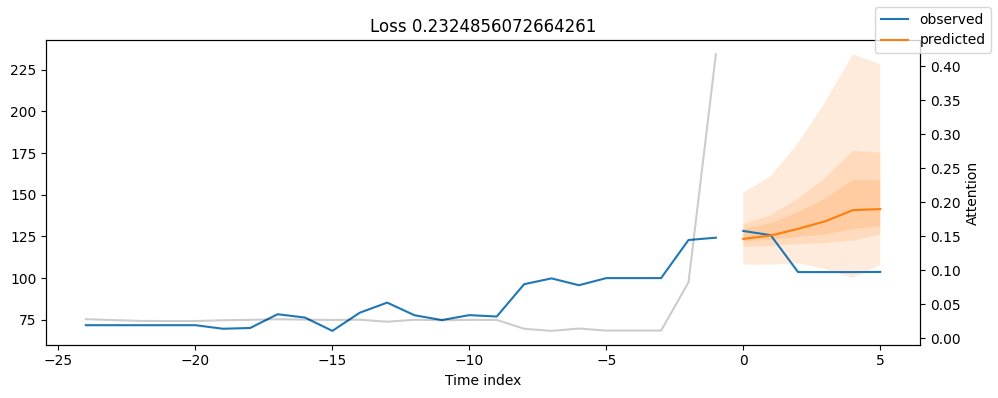

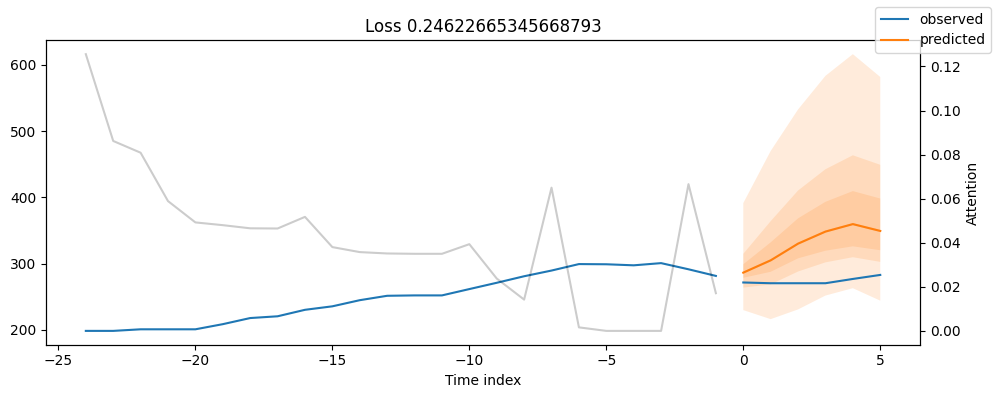

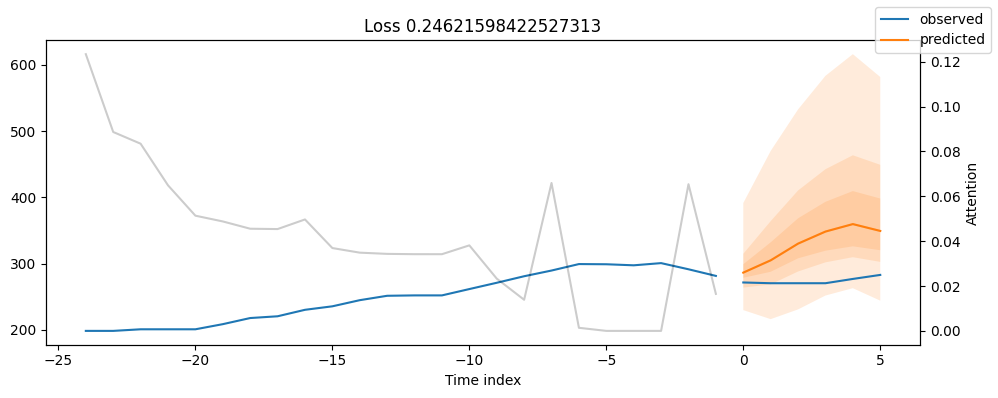

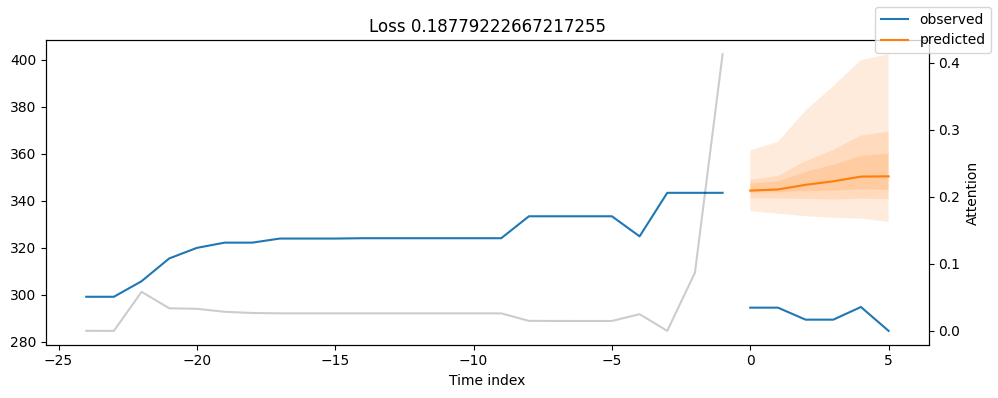

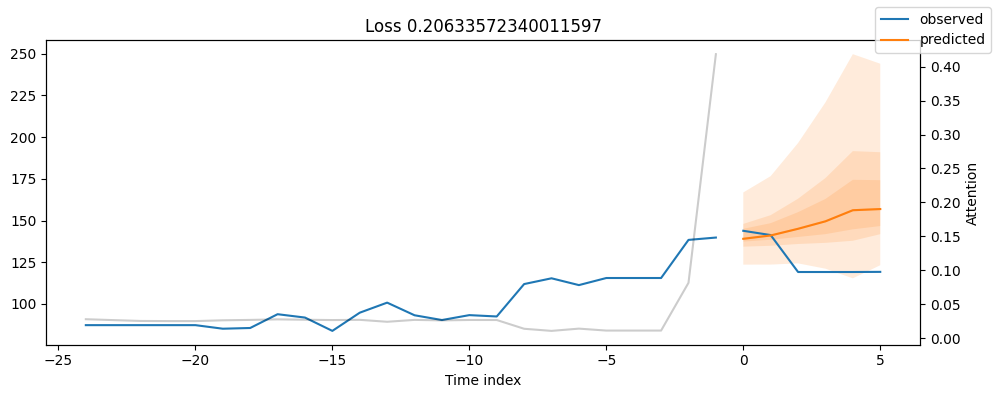

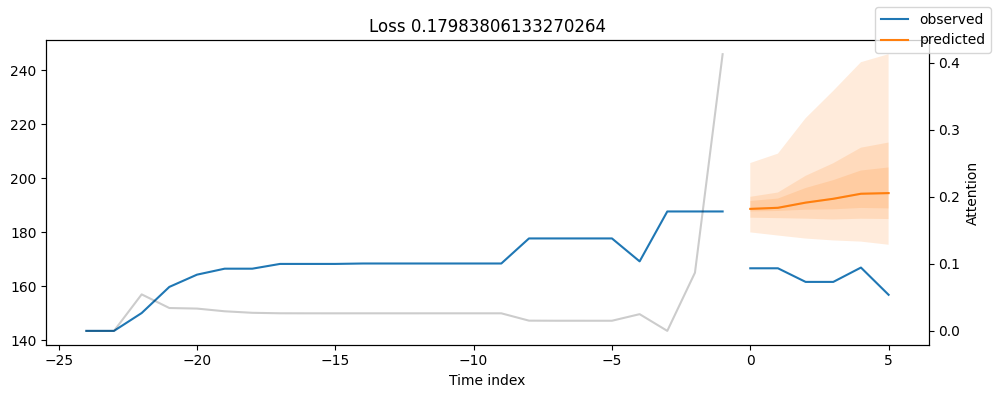

In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader, return_y=True)
mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
        ax=ax
    )

INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'valor_cumsum_fill_center': <Figure size 1000x500 with 2 Axes>,
 'valor_cumsum_fill_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'mes': <Figure size 1000x500 with 2 Axes>,
 'ano_numerico': <Figure size 1000x500 with 2 Axes>,
 'trimestre': <Figure size 1000x500 with 2 Axes>,
 'inpc_mes_value': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'valor_cumsum_fill': <Figure size 1000x500 with 2 Axes>,
 'valor_var_cumsum': <Figure size 1000x500 with 2 Axes>,
 'valor_media_movel_3m': <Figure size 1000x500 with 2 Axes>,
 'valor_tendencia': <Figure size 1000x500 with 2 Axes>,
 'valor_var_mes': <Figure size 1000x500 with 2 Axes>,
 'ind_transf_value': <Figure size 1000x500 with 2 Axes>,
 'valor_cumsum_is_real': <Figure size 1000x500 with 2 Axes>,
 'selic_media_anual': <Figure size 1000x500 with 2 Axes>,
 'codigo': <Figure size 1000x500 with 2 Axes>

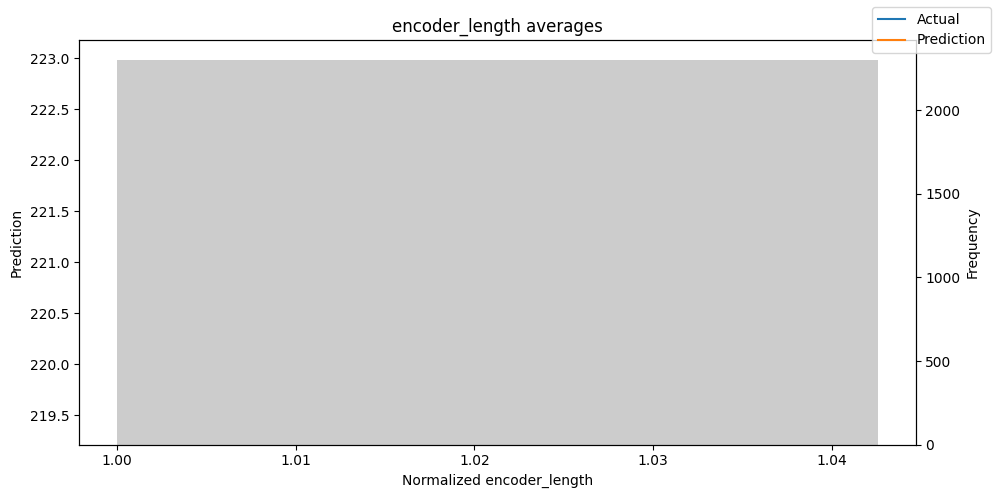

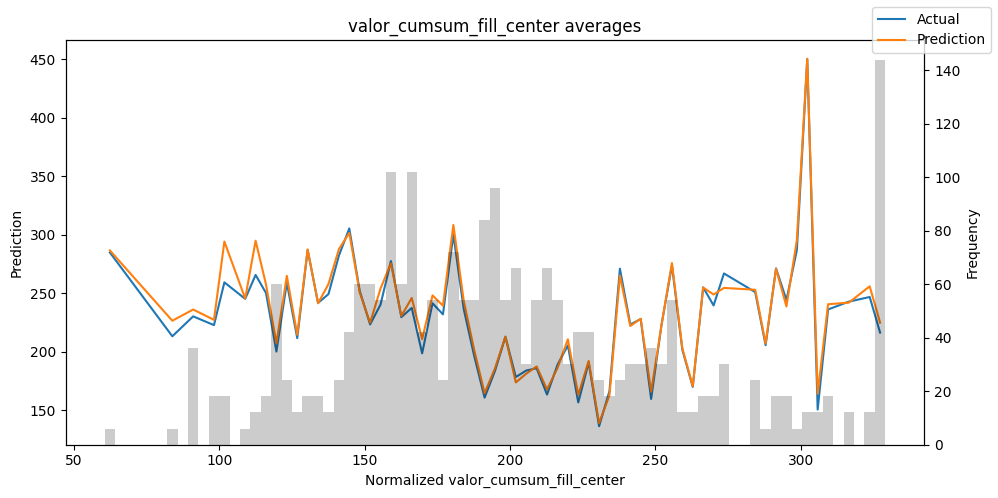

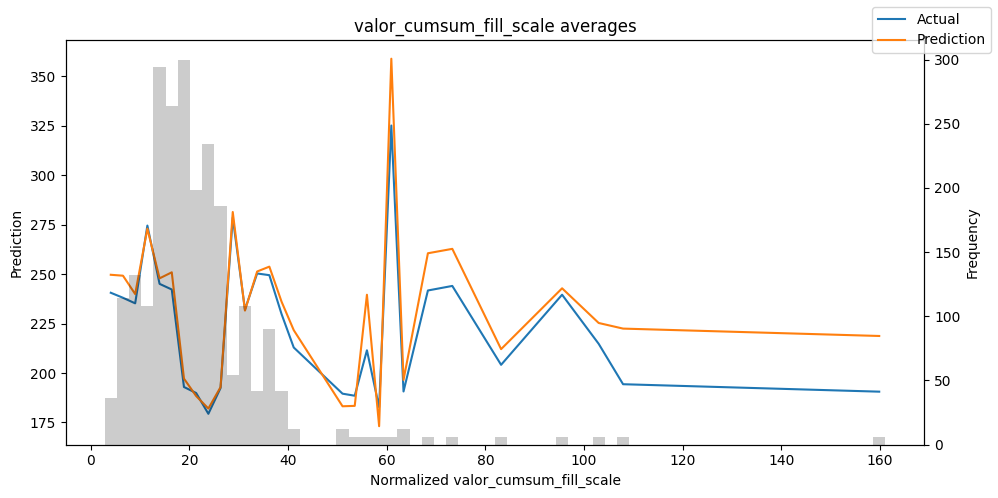

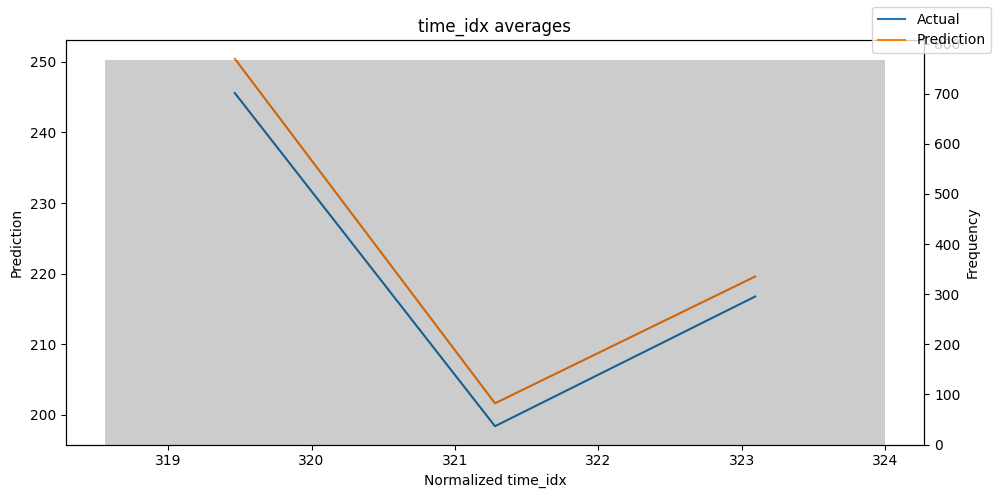

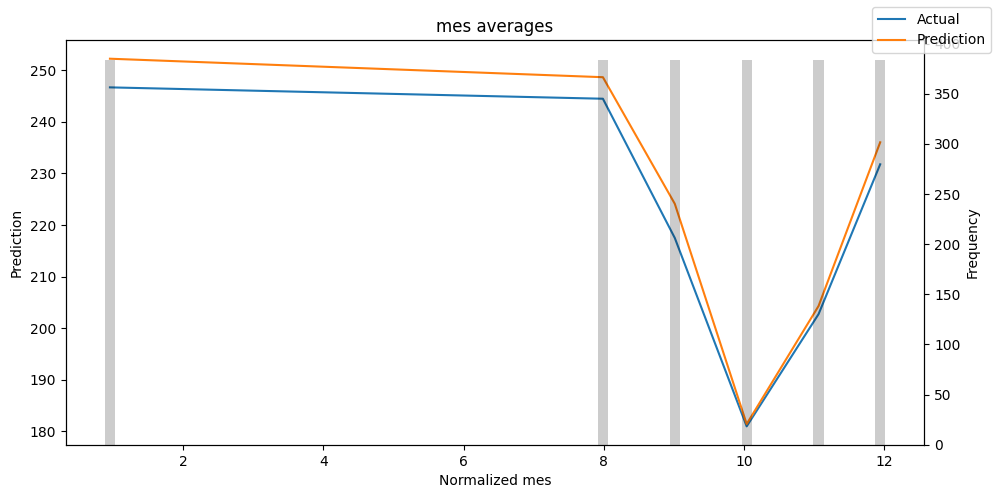

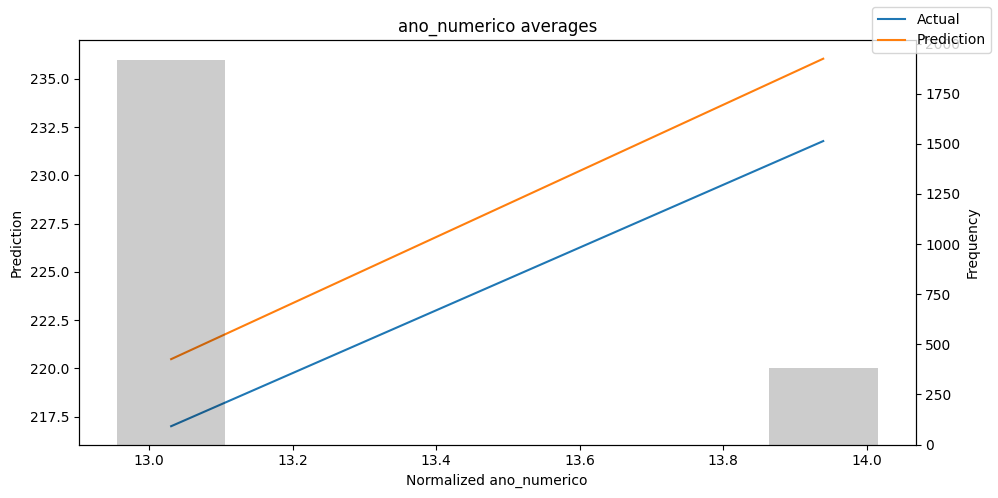

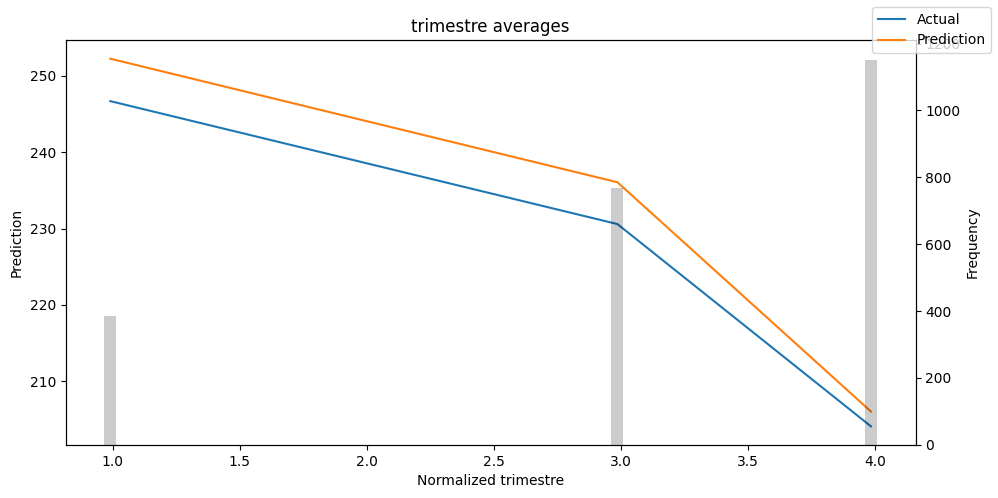

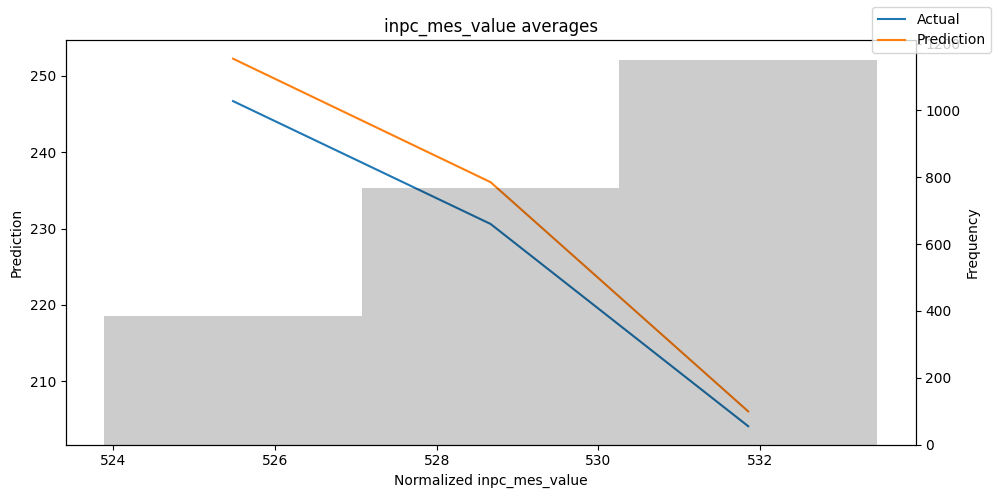

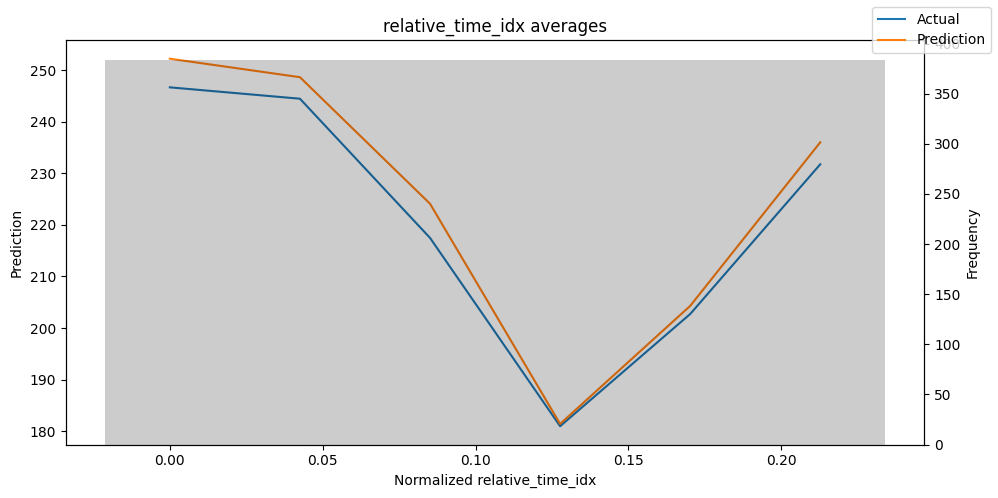

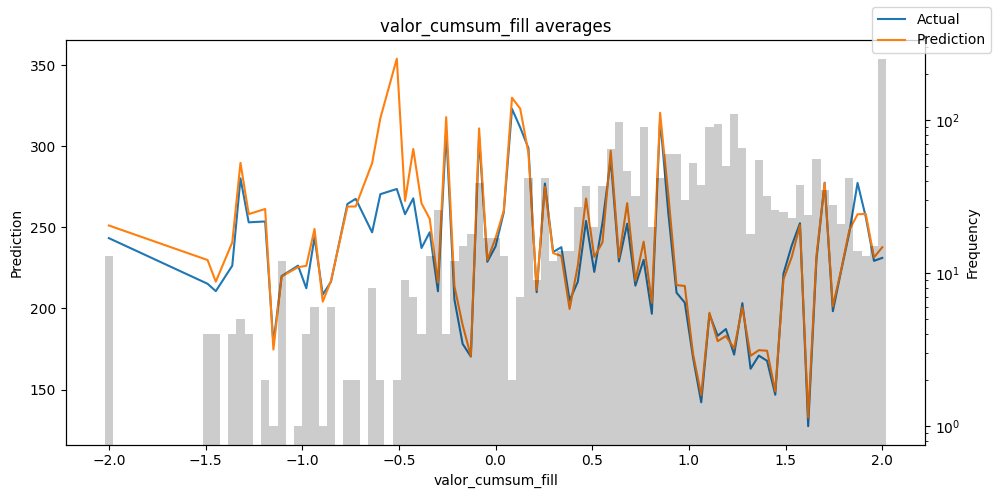

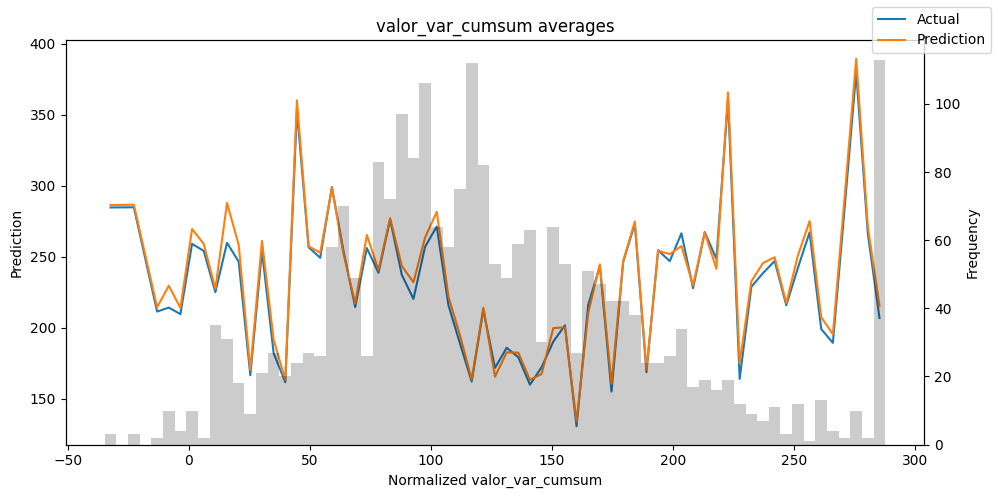

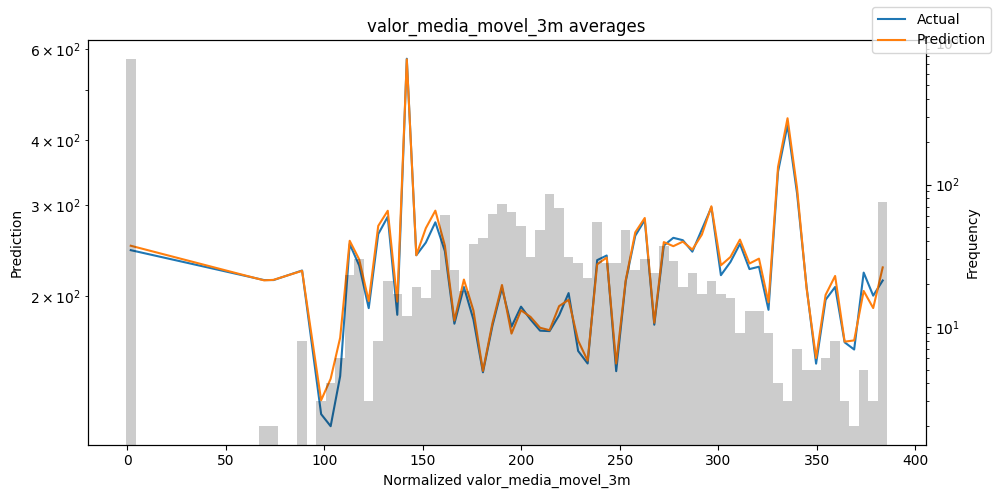

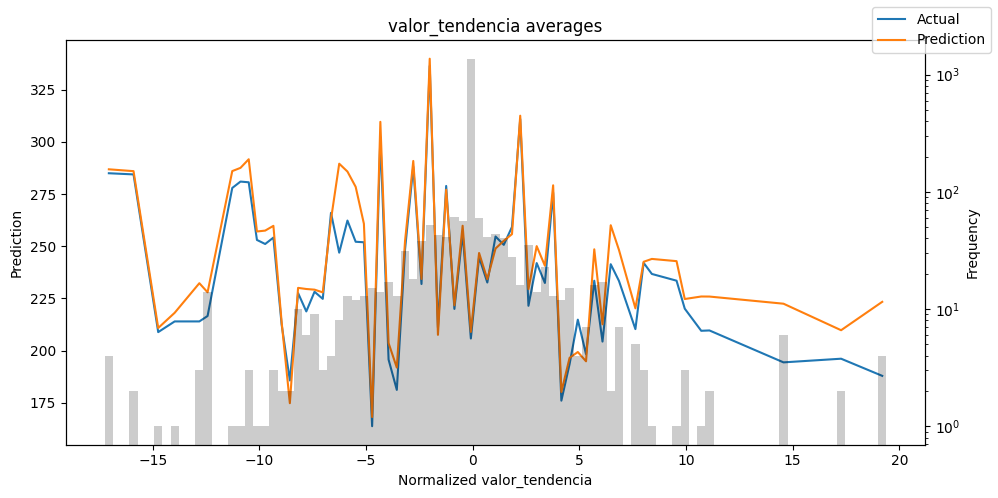

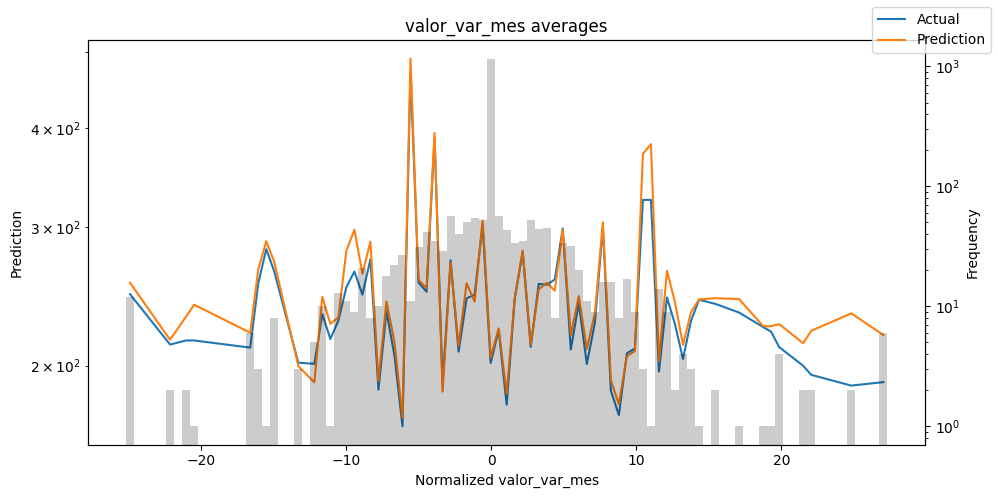

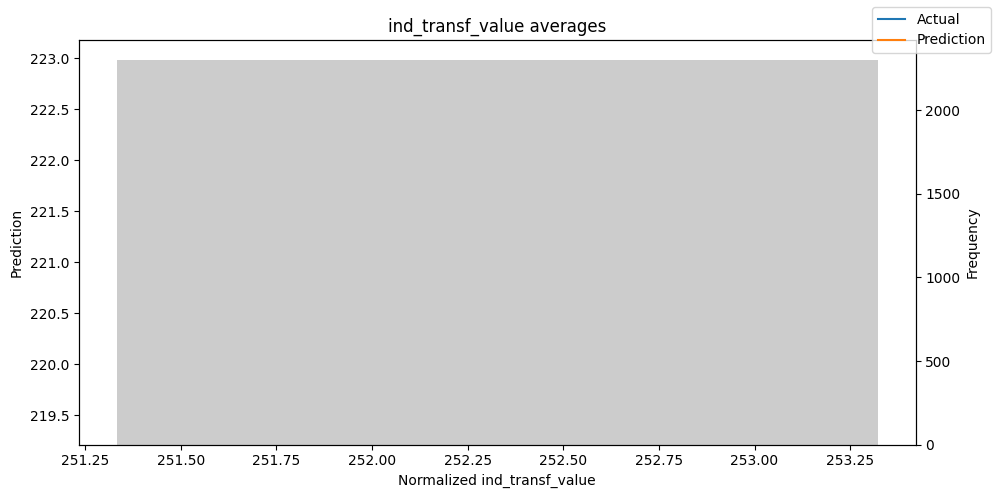

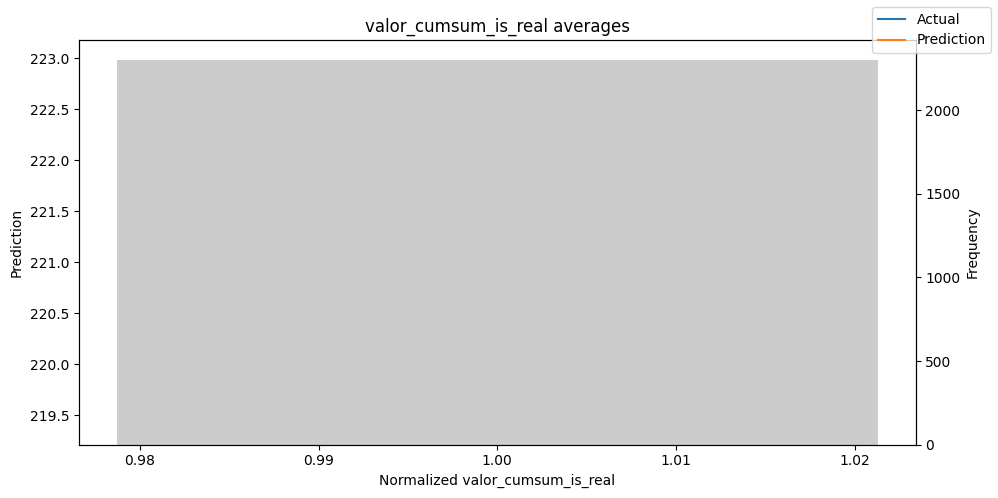

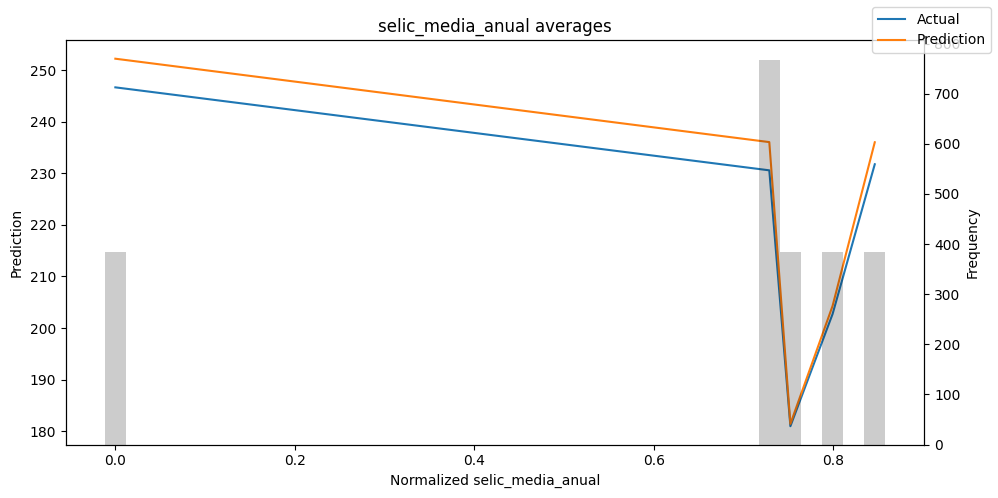

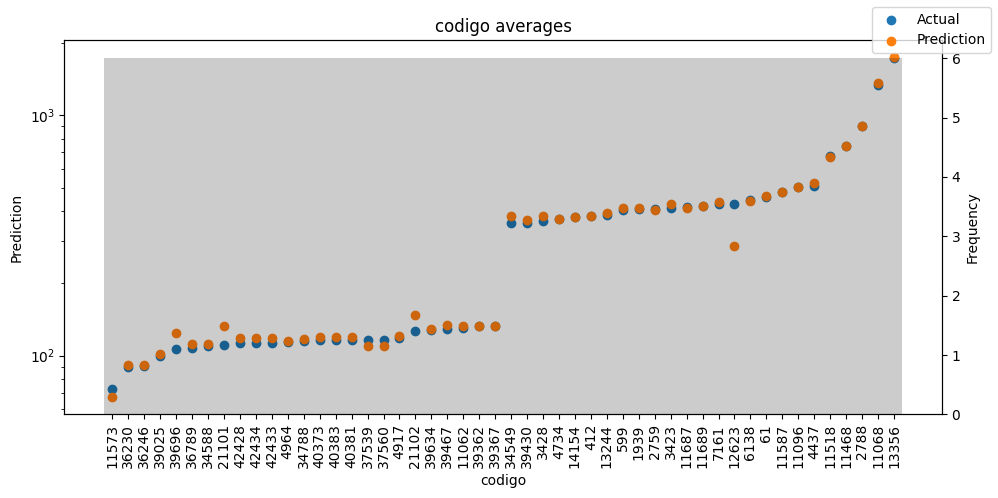

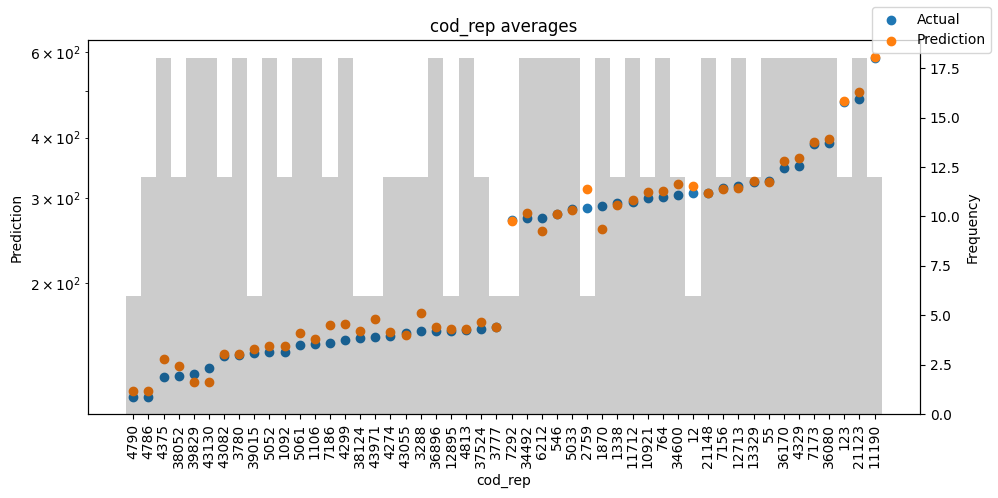

In [ ]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

**IMPORTANCIA DAS VARIAVEIS

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x325 with 1 Axes>,
 'encoder_variables': <Figure size 700x550 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

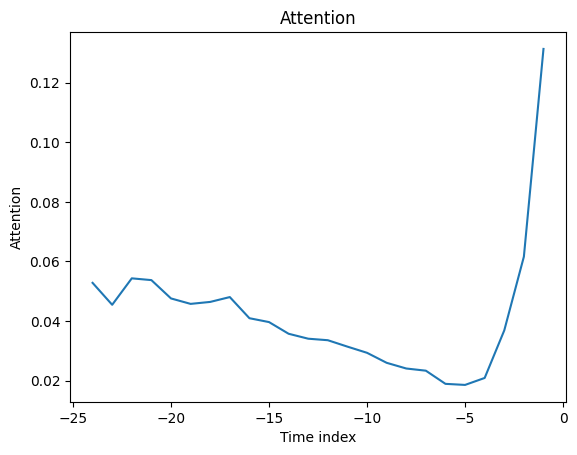

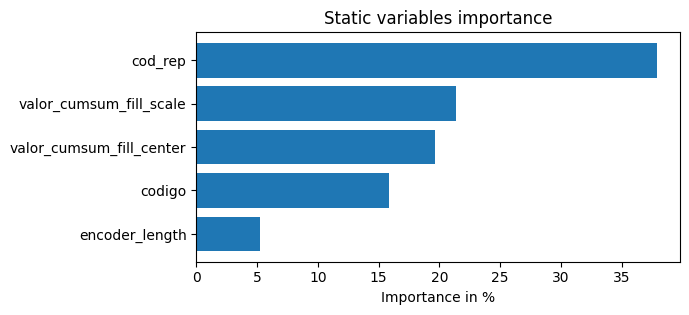

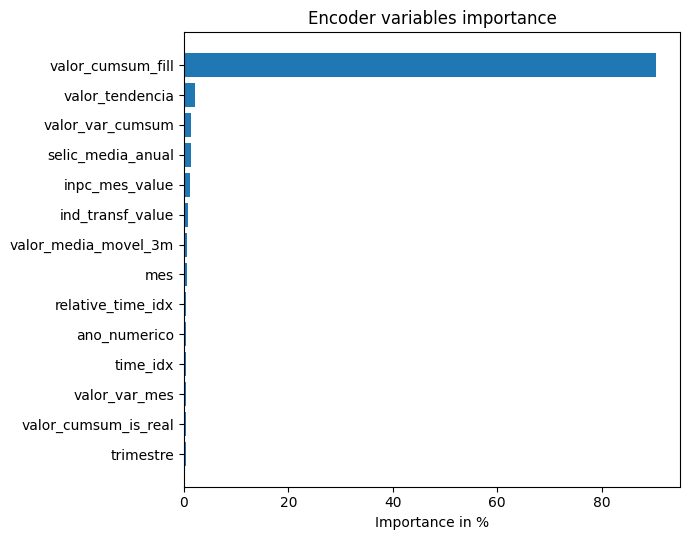

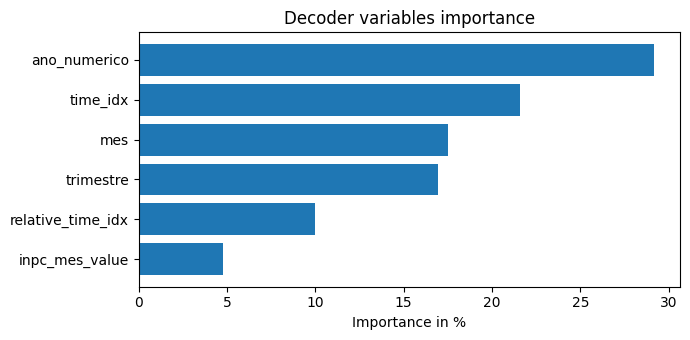

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)